In [19]:
#!pip install tensorflow 
#!pip install lightgbm

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor




In [86]:
tracks = pd.read_csv("../data/raw/tracks.tsv", sep="\t", dtype={"track_id": str})
echonest = pd.read_csv("../data/raw/echonest_features.tsv", sep="\t", dtype={"track_id": str})
spectral = pd.read_csv("../data/raw/spectral_features.tsv", sep="\t", dtype={"track_id": str})
genres = pd.read_csv("../data/raw/genres.csv")

In [87]:
print("tracks_columns :", tracks.columns)
print("echonest_columns :", echonest.columns)
print("spectral_columns :", spectral.columns)   
print("genres_columns :", genres.columns)

tracks_columns : Index(['track_id', 'album_title', 'album_tracks', 'artist_latitude',
       'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_top',
       'genres', 'genres_all', 'interest', 'listens', 'title'],
      dtype='object')
echonest_columns : Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')
spectral_columns : Index(['track_id', 'spectral_bandwidth_kurtosis_01',
       'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01',
       'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01',
       'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01',
       'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01',
       'spectral_centroid_mean_01', 'spectral_centroid_median_01',
       'spectral_centroid_min_01', 'spectral_centroid_skew_01',
       'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01',
       'spectral_rolloff_max_01',

In [89]:
def clean_cols(df):
    # Standardize column names
    df.columns = (df.columns
                    .str.lower()
                    .str.strip()
                    .str.replace(" ", "_")
                    .str.replace("-", "_")
                    .str.replace(r"[^a-zA-Z0-9_]", "", regex=True))
    return df
        
tracks = clean_cols(tracks)
echonest = clean_cols(echonest)
spectral = clean_cols(spectral)
genres = clean_cols(genres)

# Fusion
df = tracks.merge(echonest, on="track_id", how="left") \
          .merge(spectral, on="track_id", how="left")

# Conversion genres
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)

# Dictionnaire id -> nom
id_to_name = dict(zip(genres["genre_id"], genres["genre_title"]))
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]

df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)

print(f"✓ Dataset fusionné: {len(df)} lignes, {df.shape[1]} colonnes")


✓ Dataset fusionné: 99995 lignes, 45 colonnes


In [90]:
type(df.loc[0, "genres"])


list

In [28]:
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)


In [29]:
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]


In [30]:
df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)


In [31]:
df[["genre_top", "genres_names", "genres_all_names"]].head()


,genre_top,genres_names,genres_all_names
0,Hip-Hop,[Hip-Hop],[Hip-Hop]
1,Hip-Hop,[Hip-Hop],[Hip-Hop]
2,Hip-Hop,[Hip-Hop],[Hip-Hop]
3,Hip-Hop,[Hip-Hop],[Hip-Hop]
4,Hip-Hop,[Hip-Hop],[Hip-Hop]


In [32]:
# 1. Informations générales
print("Shape du dataset:", df.shape)
print("\nTypes de données:")
print(df.dtypes)


Shape du dataset: (99995, 45)

Types de données:
track_id                           object
album_title                        object
album_tracks                        int64
artist_latitude                   float64
artist_longitude                  float64
artist_name                        object
duration                            int64
favorites                           int64
genre_top                          object
genres                             object
genres_all                         object
interest                            int64
listens                             int64
title                              object
acousticness                      float64
danceability                      float64
energy                            float64
instrumentalness                  float64
liveness                          float64
speechiness                       float64
tempo                             float64
valence                           float64
spectral_bandwidth_kurtosis

In [33]:
# 2. Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])




=== VALEURS MANQUANTES ===
                  Missing_Count  Percentage
speechiness               89587   89.591480
valence                   89463   89.467473
danceability              89461   89.465473
energy                    89442   89.446472
liveness                  89442   89.446472
acousticness              89442   89.446472
tempo                     89442   89.446472
instrumentalness          89442   89.446472
artist_longitude          59788   59.790990
artist_latitude           59788   59.790990
genre_top                 55362   55.364768
album_title                 911    0.911046
title                         1    0.001000


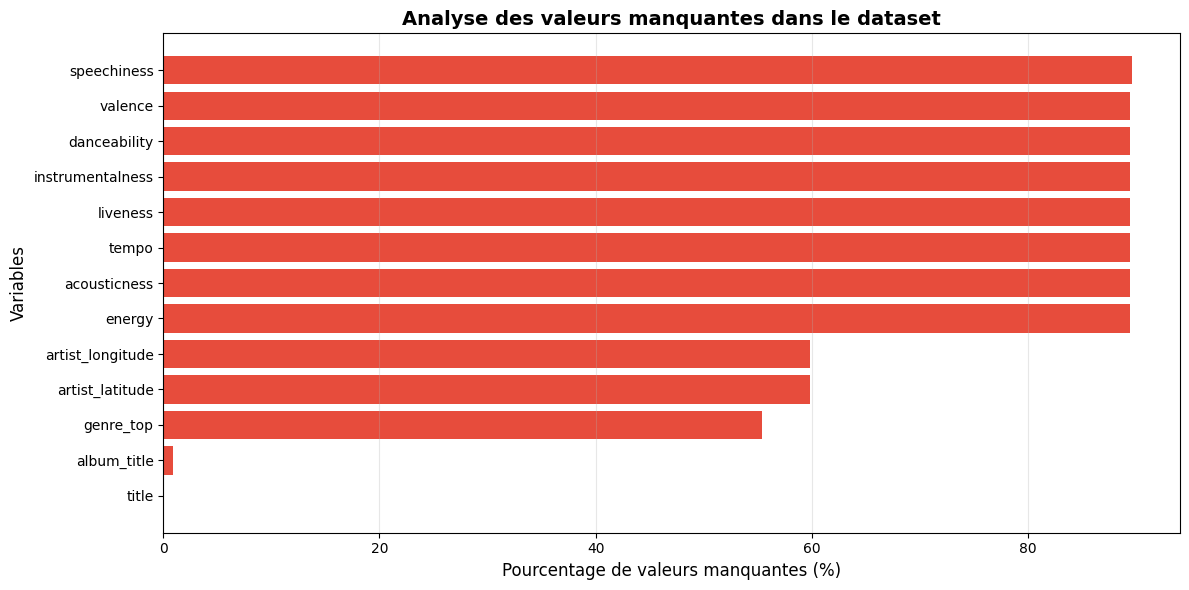

In [34]:
# Filtrer et trier
missing_to_plot = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage')

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(missing_to_plot.index, missing_to_plot['Percentage'], color='#e74c3c')

ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.set_title('Analyse des valeurs manquantes dans le dataset', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


=== CORRÉLATION ENTRE MISSING VALUES ===

Nombre de variables avec missing values: 13

Corrélations fortes (> 0.5):
  speechiness <-> valence: 0.993
  speechiness <-> danceability: 0.993
  speechiness <-> energy: 0.992
  speechiness <-> liveness: 0.992
  speechiness <-> acousticness: 0.992
  speechiness <-> tempo: 0.992
  speechiness <-> instrumentalness: 0.992
  valence <-> danceability: 1.000
  valence <-> energy: 0.999
  valence <-> liveness: 0.999
  valence <-> acousticness: 0.999
  valence <-> tempo: 0.999
  valence <-> instrumentalness: 0.999
  danceability <-> energy: 0.999
  danceability <-> liveness: 0.999
  danceability <-> acousticness: 0.999
  danceability <-> tempo: 0.999
  danceability <-> instrumentalness: 0.999
  energy <-> liveness: 1.000
  energy <-> acousticness: 1.000
  energy <-> tempo: 1.000
  energy <-> instrumentalness: 1.000
  liveness <-> acousticness: 1.000
  liveness <-> tempo: 1.000
  liveness <-> instrumentalness: 1.000
  acousticness <-> tempo: 1.000
  a

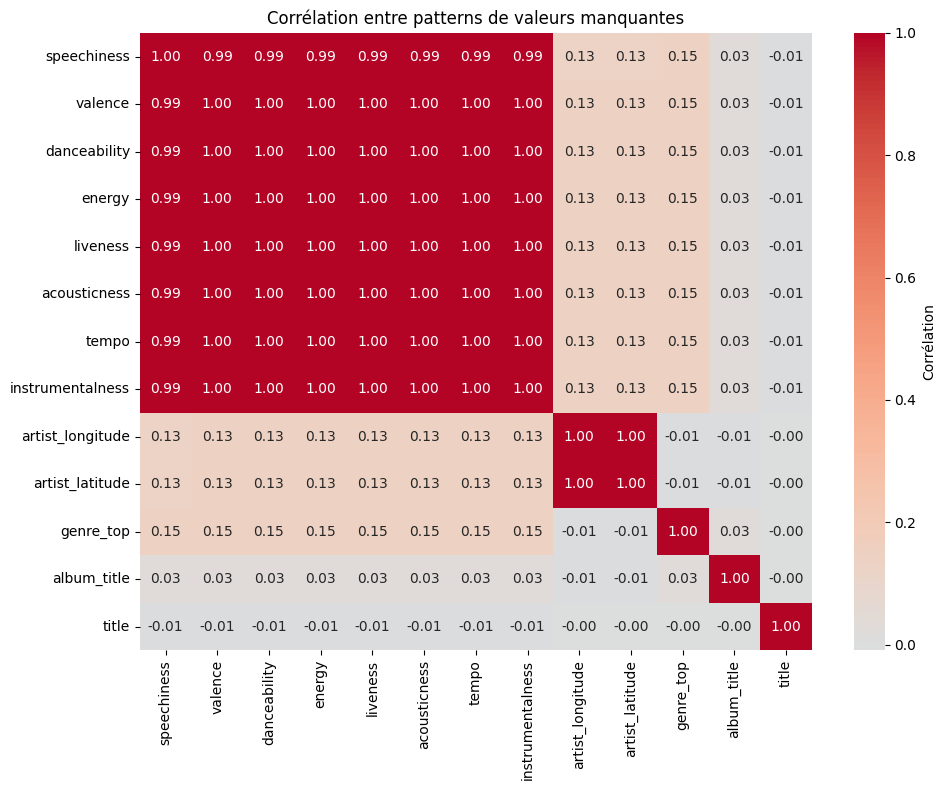

In [35]:
# Analyser si les missing values sont corrélés entre variables
print("\n=== CORRÉLATION ENTRE MISSING VALUES ===")
missing_cols = missing_df[missing_df['Missing_Count'] > 0].index.tolist()

if len(missing_cols) > 1:
    # Créer une matrice binaire (1 = missing, 0 = present)
    missing_matrix = df[missing_cols].isnull().astype(int)
    
    # Calculer la corrélation
    missing_corr = missing_matrix.corr()
    
    print(f"\nNombre de variables avec missing values: {len(missing_cols)}")
    print("\nCorrélations fortes (> 0.5):")
    
    # Afficher seulement les corrélations fortes
    for i in range(len(missing_corr.columns)):
        for j in range(i+1, len(missing_corr.columns)):
            corr_val = missing_corr.iloc[i, j]
            if abs(corr_val) > 0.5:
                print(f"  {missing_corr.columns[i]} <-> {missing_corr.columns[j]}: {corr_val:.3f}")
    
    # Heatmap si pas trop de variables
    if len(missing_cols) <= 15:
        import seaborn as sns
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, ax=ax, cbar_kws={'label': 'Corrélation'})
        plt.title('Corrélation entre patterns de valeurs manquantes')
        plt.tight_layout()
        plt.show()
else:
    print("Une seule variable a des missing values, pas de corrélation à calculer.")

In [36]:
# 3. Doublons
print(f"\nNombre de doublons (track_id): {df['track_id'].duplicated().sum()}")




Nombre de doublons (track_id): 0


In [37]:
# 4. Statistiques descriptives
print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(df[['duration', 'listens', 'interest', 'favorites']].describe())




=== STATISTIQUES DESCRIPTIVES ===
           duration        listens      interest     favorites
count  99995.000000   99995.000000  9.999500e+04  99995.000000
mean     278.034522    2403.072944  3.628631e+03      3.239962
std      294.940279    8234.085292  1.957852e+04     13.863871
min        0.000000       0.000000  2.000000e+00      0.000000
25%      151.000000     305.000000  6.020000e+02      0.000000
50%      218.000000     797.000000  1.333000e+03      1.000000
75%      307.000000    2085.000000  3.117000e+03      3.000000
max    11030.000000  543252.000000  3.293557e+06   1482.000000


In [38]:
print("\n" + "="*60)
print("DÉTECTION D'INCOHÉRENCES")
print("="*60)

# 1. DURÉE (variable cible pour Task 3)
print("\n--- DURÉE (duration) ---")
print(f"Durées négatives: {(df['duration'] < 0).sum()}")
print(f"Durées nulles (= 0): {(df['duration'] == 0).sum()}")
print(f"Durées très courtes (< 30s): {(df['duration'] < 30).sum()}")
print(f"Durées très longues (> 600s = 10min): {(df['duration'] > 600).sum()}")
print(f"Durées extrêmes (> 3600s = 1h): {(df['duration'] > 3600).sum()}")
print(f"\nMin duration: {df['duration'].min()}s")
print(f"Max duration: {df['duration'].max()}s")

# 2. COORDONNÉES GPS
print("\n--- COORDONNÉES GPS ---")
if 'artist_latitude' in df.columns and 'artist_longitude' in df.columns:
    print(f"Latitudes hors [-90, 90]: {((df['artist_latitude'] < -90) | (df['artist_latitude'] > 90)).sum()}")
    print(f"Longitudes hors [-180, 180]: {((df['artist_longitude'] < -180) | (df['artist_longitude'] > 180)).sum()}")
    print(f"Coordonnées (0, 0) - probablement invalides: {((df['artist_latitude'] == 0) & (df['artist_longitude'] == 0)).sum()}")

# 3. FEATURES ECHONEST (doivent être entre 0 et 1)
print("\n--- FEATURES ECHONEST (doivent être [0, 1]) ---")
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'speechiness', 'valence']

for feat in audio_features:
    if feat in df.columns:
        out_of_range = ((df[feat] < 0) | (df[feat] > 1)).sum()
        if out_of_range > 0:
            print(f"  ⚠️ {feat} hors [0,1]: {out_of_range} valeurs")
        else:
            print(f"  ✓ {feat}: OK")

# 4. TEMPO (devrait être positif et raisonnable)
print("\n--- TEMPO ---")
if 'tempo' in df.columns:
    print(f"Tempo négatif: {(df['tempo'] < 0).sum()}")
    print(f"Tempo = 0: {(df['tempo'] == 0).sum()}")
    print(f"Tempo très élevé (> 300 BPM): {(df['tempo'] > 300).sum()}")
    print(f"Range: [{df['tempo'].min():.1f}, {df['tempo'].max():.1f}] BPM")

# 5. FEATURES SPECTRALES (vérifier valeurs infinies/NaN)
print("\n--- FEATURES SPECTRALES ---")
spectral_cols = [col for col in df.columns if 'spectral' in col]
if spectral_cols:
    print(f"Valeurs infinies: {np.isinf(df[spectral_cols]).sum().sum()}")
    print(f"NaN dans spectrales (en plus des missing): {df[spectral_cols].isna().sum().sum()}")
    
    # Vérifier valeurs négatives (certaines features peuvent être négatives)
    negative_spectral = (df[spectral_cols] < 0).sum().sum()
    print(f"Valeurs négatives: {negative_spectral}")

# 6. STATISTIQUES D'ÉCOUTE
print("\n--- STATISTIQUES D'ÉCOUTE ---")
if 'listens' in df.columns:
    print(f"Listens négatifs: {(df['listens'] < 0).sum()}")
    print(f"Listens = 0: {(df['listens'] == 0).sum()}")
    
if 'interest' in df.columns:
    print(f"Interest négatif: {(df['interest'] < 0).sum()}")
    print(f"Interest = 0: {(df['interest'] == 0).sum()}")

if 'favorites' in df.columns:
    print(f"Favorites négatifs: {(df['favorites'] < 0).sum()}")

# 7. GENRE_TOP (variable cible Task 1)
print("\n--- GENRE_TOP (target Task 1) ---")
print(f"Genre_top manquants: {df['genre_top'].isnull().sum()}")
print(f"Genres uniques: {df['genre_top'].nunique()}")


DÉTECTION D'INCOHÉRENCES

--- DURÉE (duration) ---
Durées négatives: 0
Durées nulles (= 0): 4
Durées très courtes (< 30s): 1754
Durées très longues (> 600s = 10min): 5527
Durées extrêmes (> 3600s = 1h): 123

Min duration: 0s
Max duration: 11030s

--- COORDONNÉES GPS ---
Latitudes hors [-90, 90]: 0
Longitudes hors [-180, 180]: 0
Coordonnées (0, 0) - probablement invalides: 0

--- FEATURES ECHONEST (doivent être [0, 1]) ---
  ✓ acousticness: OK
  ✓ danceability: OK
  ✓ energy: OK
  ✓ instrumentalness: OK
  ✓ liveness: OK
  ✓ speechiness: OK
  ✓ valence: OK

--- TEMPO ---
Tempo négatif: 0
Tempo = 0: 19
Tempo très élevé (> 300 BPM): 0
Range: [0.0, 251.1] BPM

--- FEATURES SPECTRALES ---
Valeurs infinies: 0
NaN dans spectrales (en plus des missing): 0
Valeurs négatives: 94478

--- STATISTIQUES D'ÉCOUTE ---
Listens négatifs: 0
Listens = 0: 1
Interest négatif: 0
Interest = 0: 0
Favorites négatifs: 0

--- GENRE_TOP (target Task 1) ---
Genre_top manquants: 55362
Genres uniques: 16


In [39]:
# Statistiques descriptives des variables numériques :
# - moyenne, écart-type, min, max, quartiles

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols].describe().T  # .T pour avoir une vue plus lisible



,count,mean,std,min,25%,50%,75%,max
album_tracks,99995.0,19.908645,40.510849,-1.000000e+00,7.000000,11.000000,18.000000,6.520000e+02
artist_latitude,40207.0,39.967832,18.766913,-4.587450e+01,39.271398,41.823989,50.079079,6.728601e+01
artist_longitude,40207.0,-35.443236,65.670545,-1.575269e+02,-78.868915,-72.669067,5.007986,1.752770e+02
duration,99995.0,278.034522,294.940279,0.000000e+00,151.000000,218.000000,307.000000,1.103000e+04
favorites,99995.0,3.239962,13.863871,0.000000e+00,0.000000,1.000000,3.000000,1.482000e+03
interest,99995.0,3628.631112,19578.522967,2.000000e+00,602.000000,1333.000000,3117.000000,3.293557e+06
listens,99995.0,2403.072944,8234.085292,0.000000e+00,305.000000,797.000000,2085.000000,5.432520e+05
acousticness,10553.0,0.489379,0.384781,9.491000e-07,0.070923,0.486664,0.897625,9.957965e-01
danceability,10534.0,0.506784,0.189812,5.143514e-02,0.367335,0.511994,0.651299,9.686447e-01
energy,10553.0,0.541650,0.274799,2.028170e-05,0.330205,0.554549,0.774238,9.999637e-01


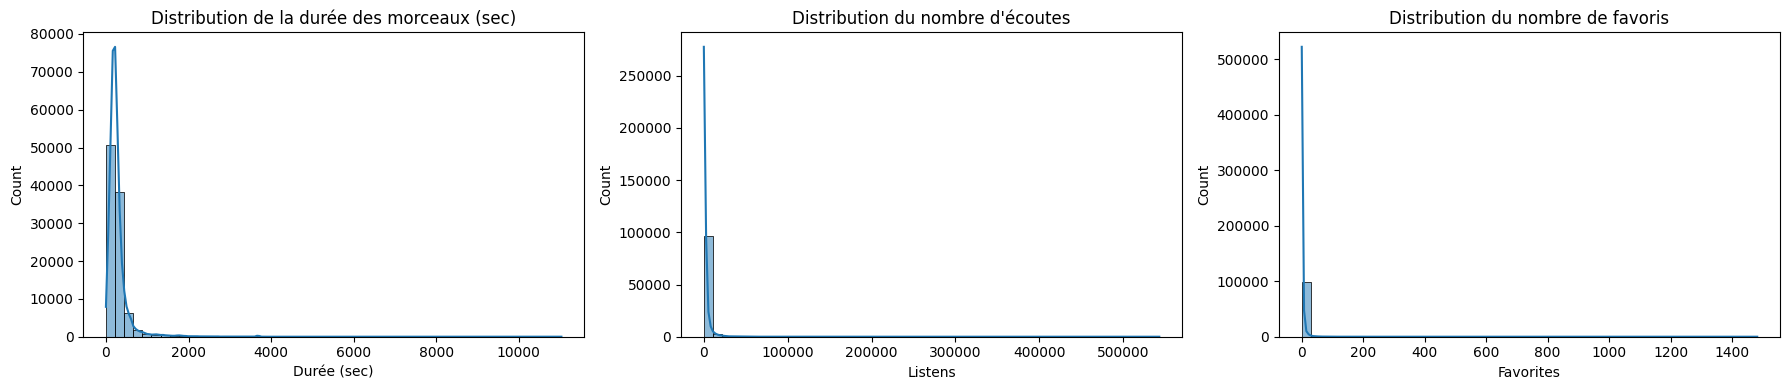

In [40]:
# Visualisation des distributions pour quelques variables clés 

fig, axes = plt.subplots(1, 3, figsize=(18,4))

sns.histplot(df["duration"], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Distribution de la durée des morceaux (sec)")
axes[0].set_xlabel("Durée (sec)")

sns.histplot(df["listens"], bins=50, ax=axes[1], kde=True)
axes[1].set_title("Distribution du nombre d'écoutes")
axes[1].set_xlabel("Listens")

sns.histplot(df["favorites"], bins=50, ax=axes[2], kde=True)
axes[2].set_title("Distribution du nombre de favoris")
axes[2].set_xlabel("Favorites")

plt.tight_layout()
plt.show()


Effectifs par genre_top :
genre_top
NaN                    55362
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64


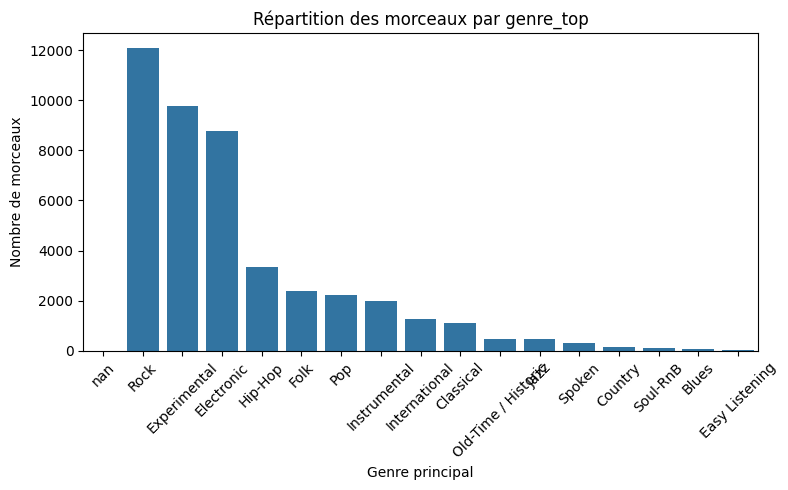

In [41]:
# Répartition des morceaux par genre_top (étiquette principale).
# On regarde d'abord les effectifs, puis on trace un barplot.

genre_counts = df["genre_top"].value_counts(dropna=False)
print("Effectifs par genre_top :")
print(genre_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="genre_top", order=genre_counts.index)
plt.title("Répartition des morceaux par genre_top")
plt.xlabel("Genre principal")
plt.ylabel("Nombre de morceaux")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Exemple d'analyse multi-variée simple :
# Durée moyenne des morceaux par genre_top.

duration_by_genre = df.groupby("genre_top")["duration"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
duration_by_genre


,count,mean,median
genre_top,,,
Spoken,323,678.603715,240.0
Jazz,484,378.723140,310.5
Experimental,9752,367.719647,263.0
Classical,1129,303.235607,190.0
International,1256,292.592357,236.0
Easy Listening,24,289.291667,199.0
Soul-RnB,131,265.984733,239.0
Electronic,8769,264.536663,242.0
Blues,79,251.987342,228.0


In [43]:
# 4.1 Transformations de variables numériques

# Log-transform pour réduire l'asymétrie des distributions
df["log_duration"] = np.log1p(df["duration"])
df["log_listens"] = np.log1p(df["listens"])
df["log_favorites"] = np.log1p(df["favorites"])

# Durée en minutes (plus interprétable)
df["duration_min"] = df["duration"] / 60

# Ratio favoris / écoutes (popularité conditionnelle)
df["favorites_per_listen"] = df["favorites"] / (df["listens"] + 1)


In [44]:
# 4.2 Encodage de la variable cible genre_top

# On garde uniquement les lignes avec genre_top renseigné pour la future classification
df_classif = df[~df["genre_top"].isna()].copy()

# Vérification des classes
genre_counts = df_classif["genre_top"].value_counts()
genre_counts

genre_top
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64

In [45]:
# Encodage label -> entier (si besoin)
from sklearn.preprocessing import LabelEncoder

le_genre = LabelEncoder()
df_classif["genre_encoded"] = le_genre.fit_transform(df_classif["genre_top"])


In [46]:
# 4.3 Sous-ensemble avec toutes les features Echonest disponibles

echonest_cols = ["acousticness", "danceability", "energy", "instrumentalness",
                 "liveness", "speechiness", "valence", "tempo"]

df_audio = df_classif.dropna(subset=echonest_cols).copy()
print("Taille du sous-ensemble audio complet :", df_audio.shape)



Taille du sous-ensemble audio complet : (6867, 51)


In [47]:
df.to_csv("df_phase1.csv", index=False) #merge de df mais avec les noms de genre

In [48]:
df_classif.to_csv("df_classif_phase1.csv", index=False) #sous ensemble de df sans les valeurs manquantes sur genre_top


In [49]:
df_audio.to_csv("df_audio_phase1.csv", index=False) #sous ensemble de df_classif sans les valeurs manquantes sur features de echonest


# Task 1 - Predict the original genre
## A multi-class classification problem. Try to reach the best performance level and also explain possible issue


# Prédiction du genre musical principal (`genre_top`)


## Formulation du problème

L’objectif est de prédire le genre musical principal (`genre_top`) à partir de métadonnées numériques et de descripteurs audio.  
Il s’agit d’un **problème de classification multi-classes** avec 16 genres possibles.

Le jeu de données est fortement déséquilibré et contient de nombreuses valeurs manquantes, ce qui impose un prétraitement rigoureux et une évaluation adaptée des performances, au-delà de la simple accuracy.


## Méthodologie

### Préparation des données

- Seules les pistes avec un `genre_top` connu ont été utilisées pour l’apprentissage.
- Les variables explicatives ont été limitées aux variables numériques.
- Les valeurs manquantes dans les features ont été traitées par **imputation par la médiane** (apprise uniquement sur le jeu d’entraînement afin d’éviter toute fuite de données).
- Les données ont ensuite été standardisées avec `StandardScaler`, ajusté uniquement sur le jeu d’entraînement.
- Le jeu de données a été découpé en ensembles d’entraînement, validation et test afin de :
    - ajuster les hyperparamètres,
    - comparer objectivement les modèles entre eux,
    - éviter toute fuite d’information depuis le test,
    - obtenir une mesure réaliste de généralisation.
- Le jeu de validation a été utilisé pour comparer les performances des modèles et sélectionner le modèle final, tandis que le jeu de test a été réservé exclusivement à l’évaluation finale.



In [50]:
le = LabelEncoder()
y = le.fit_transform(df_classif["genre_top"])
X = df_classif.drop(columns=["genre_top", "track_id", "genre_encoded", "genres", "genres_all", "genres_names", "genres_all_names"])
X = X.select_dtypes(include=[np.number]) #include=["number"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

#Imputer les Nan des features pour l'entrainement
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression – Validation
Accuracy: 0.36881021734259467
Balanced accuracy: 0.4306323138934024
F1 macro: 0.2835321589988946
F1 weighted: 0.4240393934132487

Classification report (validation):
              precision    recall  f1-score   support

           0       0.01      0.12      0.02         8
           1       0.35      0.58      0.44       113
           2       0.02      0.56      0.05        16
           3       0.01      0.67      0.02         3
           4       0.63      0.25      0.36       877
           5       0.64      0.38      0.48       975
           6       0.27      0.40      0.33       237
           7       0.44      0.48      0.46       333
           8       0.36      0.30      0.33       200
           9       0.16      0.18      0.17       126
          10       0.12      0.29      0.17        49
          11       0.73      0.92      0.81        49
          12       0.22      0.19      0.20       223
          13       0.73      0.43      0.54 

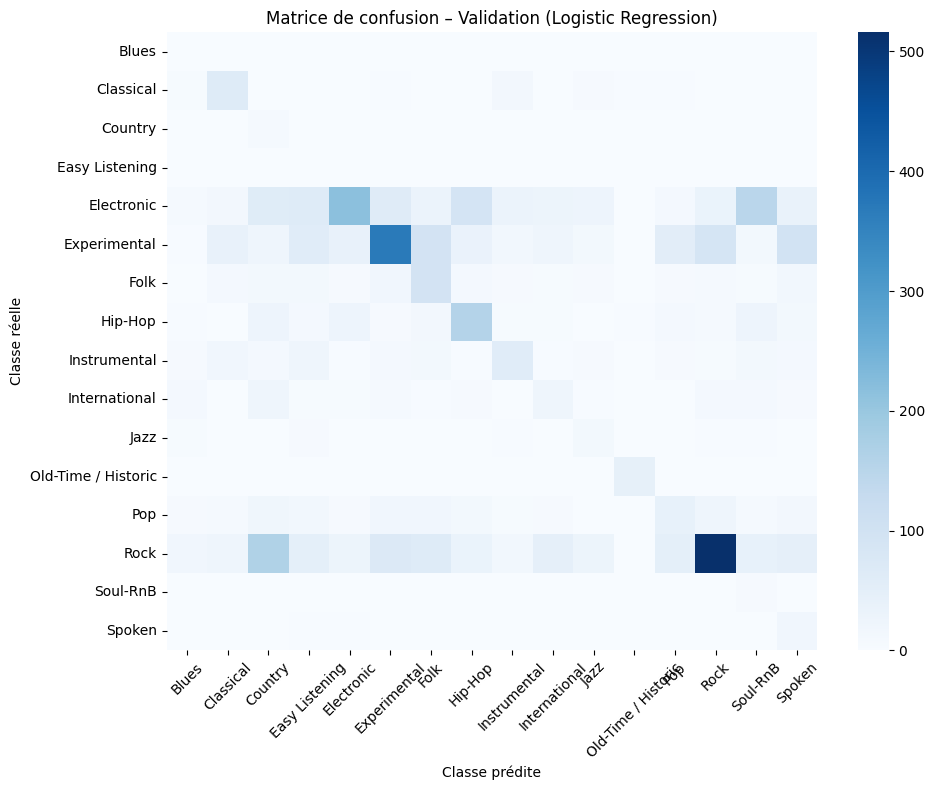

Logistic Regression – Test (final)
Accuracy: 0.3835125448028674
Balanced accuracy: 0.48607143763459526
F1 macro: 0.28793977634507717
F1 weighted: 0.4359680508491513

Classification report (test):
              precision    recall  f1-score   support

           0       0.07      0.75      0.14         8
           1       0.36      0.61      0.45       113
           2       0.03      0.62      0.06        16
           3       0.00      0.50      0.01         2
           4       0.63      0.27      0.38       877
           5       0.65      0.41      0.50       975
           6       0.25      0.35      0.29       238
           7       0.45      0.46      0.46       334
           8       0.36      0.32      0.34       201
           9       0.13      0.17      0.15       125
          10       0.12      0.27      0.17        48
          11       0.57      0.88      0.69        49
          12       0.22      0.17      0.19       224
          13       0.74      0.44      0.56    

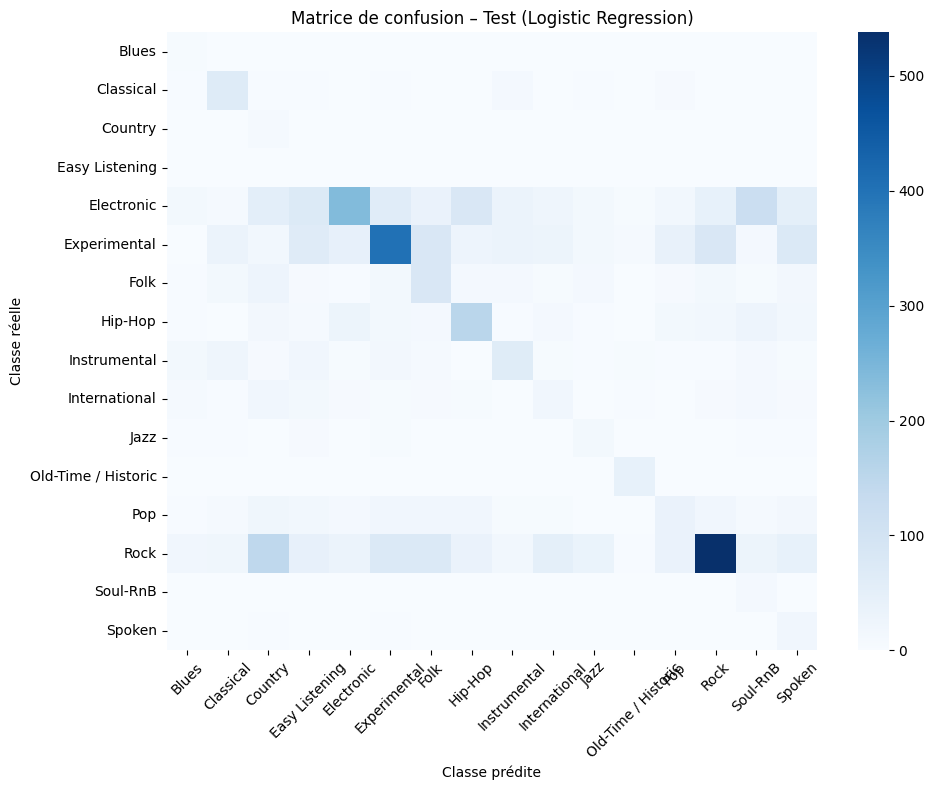

In [51]:
# Logistic Regression
logreg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
logreg.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = logreg.predict(X_val)

print("="*60)
print("Logistic Regression – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Logistic Regression)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = logreg.predict(X_test)

print("="*60)
print("Logistic Regression – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Logistic Regression)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

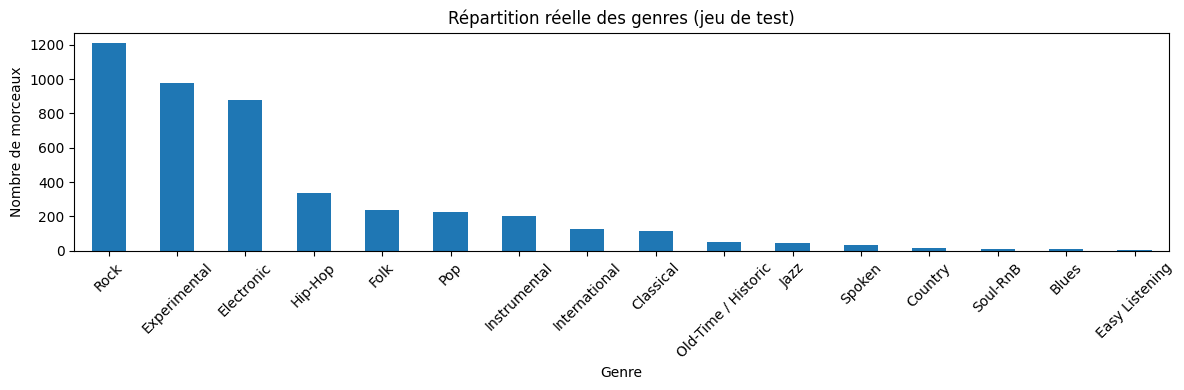

In [52]:
# déjà affiché plus haut

dist = pd.Series(le.inverse_transform(y_test)).value_counts()

plt.figure(figsize=(12,4))
dist.plot(kind="bar")
plt.title("Répartition réelle des genres (jeu de test)")
plt.ylabel("Nombre de morceaux")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Logistic Regression — Interprétation des résultats

## Performance globale

Les performances obtenues avec la régression logistique sont relativement faibles au regard de la complexité du problème, qui correspond à une classification multi-classes sur des genres musicaux fortement imbriqués.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 36,9 % | 43,1 % | 0,28 | 0,42 |
| Test | 38,3 % | 48,5 % | 0,29 | 0,44 |


### Interprétation

Une accuracy avoisinant 38 % signifie qu’environ un morceau sur trois est correctement classé, ce qui reste faible pour une application réelle. La *balanced accuracy*, légèrement supérieure à l’accuracy, suggère que certaines classes peu représentées sont parfois détectées, mais cette amélioration se fait au prix d’une forte dégradation de la précision.

Le F1 macro très bas (≈ 0,29) confirme que, lorsque l’on considère équitablement chaque genre, les performances sont médiocres. À l’inverse, le F1 weighted plus élevé (≈ 0,44) traduit principalement la bonne reconnaissance des genres majoritaires. Le modèle est donc fortement biaisé en faveur des classes les plus fréquentes.


## Analyse par classe

### Classes correctement reconnues

Quelques genres présentent des scores satisfaisants :

- **Classe 11** : rappel ≈ 0,88 et F1 ≈ 0,69.  
  Cette classe est bien identifiable par le modèle, probablement en raison de caractéristiques distinctives.
- **Classe 13** : F1 ≈ 0,55, avec un bon rappel, malgré certaines confusions.
- **Classes 5 et 7** : F1 compris entre 0,46 et 0,50, correspondant à des genres dominants du jeu de données.


### Classes mal apprises

Les classes rares sont, quant à elles, très mal prédites :

- **Classe 3** : F1 ≈ 0,01, pratiquement jamais reconnue.
- **Classes 0, 2, 14 et 15** : F1 < 0,15, performances instables et prédictions souvent incorrectes.
- Tendance marquée à confondre ces genres rares avec des classes majoritaires.


### Déséquilibre structurel des données

Le contraste important entre le F1 macro et le F1 weighted met en évidence un déséquilibre marqué dans l’apprentissage du modèle. Malgré l’utilisation de `class_weight="balanced"`, les données dominantes continuent à imposer leur influence, rendant difficile l’apprentissage des classes minoritaires.


## Limites de la régression logistique

### 1. Nature linéaire du modèle

La régression logistique repose sur des frontières linéaires, qui ne conviennent pas à la complexité des genres musicaux. Les relations entre caractéristiques audio et genres sont fortement non linéaires, ce que ce modèle ne peut capter.

### 2. Représentation limitée des données

Les variables utilisées — essentiellement des métadonnées et des statistiques audio simples — ne décrivent pas assez finement :

- le timbre,
- l’harmonie,
- l’instrumentation,
- les patterns rythmiques.

### 3. Déséquilibre extrême des classes

Certaines classes ne comportent que quelques dizaines d’exemples. Dans ces conditions, même avec une pondération des classes, l’apprentissage reste instable.


## Conclusion

La régression logistique constitue une **baseline pertinente**, mais clairement insuffisante dans ce contexte.

> Bien que le modèle atteigne environ 38 % d’accuracy, il échoue à représenter correctement la complexité du problème et la diversité des genres musicaux.

Ces résultats confirment que la performance ne peut pas être évaluée uniquement à l’aide de l’accuracy : l’analyse du F1 macro, de la balanced accuracy et des performances par classe est indispensable.


## Problèmes structurels identifiés

- Déséquilibre marqué entre les classes.
- Représentation indirecte du signal audio.
- Absence de caractéristiques riches comme les MFCC ou les spectrogrammes.
- Incapacité du modèle linéaire à capturer des frontières complexes.

La régression logistique confirme ainsi la nécessité d’utiliser des modèles non linéaires plus expressifs pour espérer obtenir des performances significativement meilleures.


Random Forest – Validation
Accuracy: 0.634998879677347
Balanced accuracy: 0.39528070575298313
F1 macro: 0.4396221459170402
F1 weighted: 0.6133999388123724

Classification report (validation):


c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.78      0.77      0.78       113
           2       1.00      0.06      0.12        16
           3       0.00      0.00      0.00         3
           4       0.59      0.69      0.64       877
           5       0.65      0.75      0.69       975
           6       0.70      0.37      0.48       237
           7       0.70      0.45      0.55       333
           8       0.53      0.40      0.45       200
           9       0.93      0.20      0.33       126
          10       0.83      0.20      0.33        49
          11       0.96      0.98      0.97        49
          12       0.91      0.18      0.30       223
          13       0.61      0.80      0.69      1208
          14       0.00      0.00      0.00        13
          15       0.75      0.36      0.49        33

    accuracy                           0.63      4463
   macro avg       0.68   

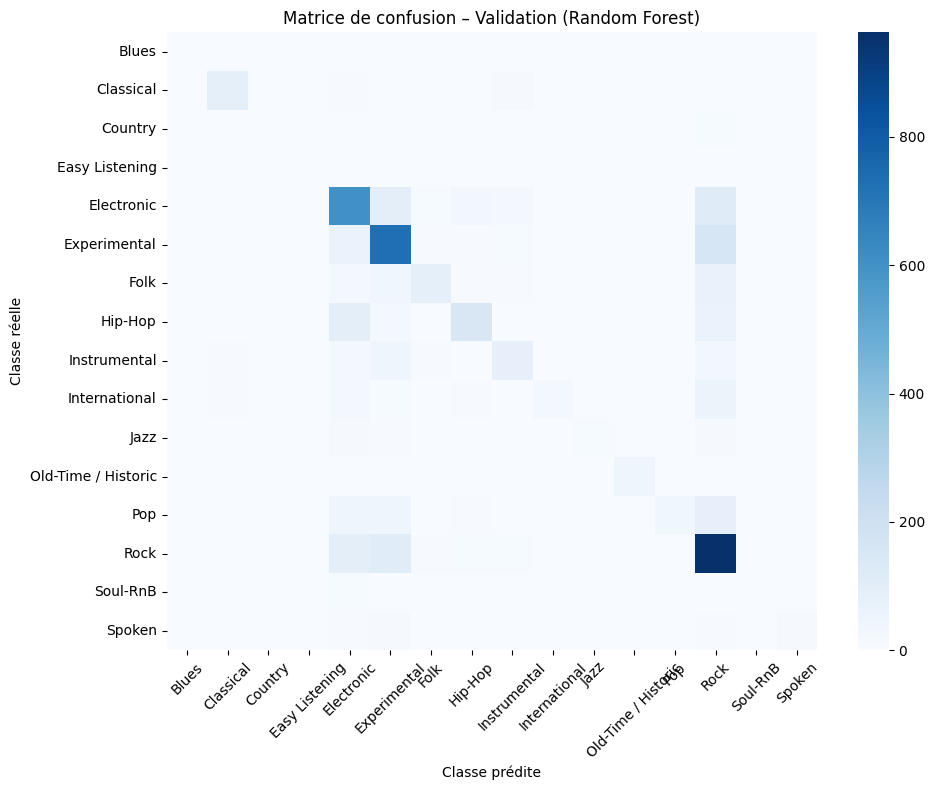

Random Forest – Test (final)
Accuracy: 0.6297043010752689
Balanced accuracy: 0.38768332275867984
F1 macro: 0.4417512842226883
F1 weighted: 0.6076370383042351

Classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.87      0.77      0.82       113
           2       1.00      0.06      0.12        16
           3       0.00      0.00      0.00         2
           4       0.57      0.67      0.62       877
           5       0.63      0.74      0.68       975
           6       0.69      0.36      0.47       238
           7       0.75      0.42      0.54       334
           8       0.64      0.48      0.55       201
           9       0.74      0.16      0.26       125
          10       0.75      0.12      0.21        48
          11       0.93      0.86      0.89        49
          12       0.95      0.18      0.30       224
          13       0.62      0.80      0.70      1209


c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Ralph\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

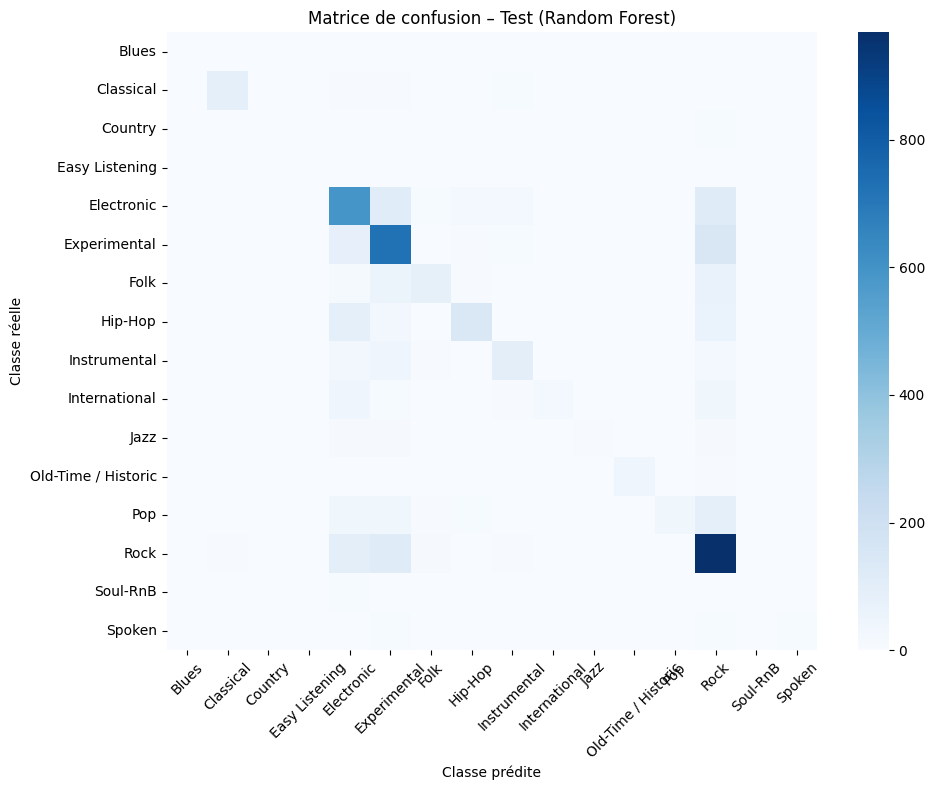

In [53]:
rf = RandomForestClassifier(
    n_estimators=300,      # nombre d’arbres
    max_depth=None,       # profondeur (None = libre)
    random_state=42,
    n_jobs=-1,            # utilise tous les cœurs
    class_weight="balanced"   # utile si classes déséquilibrées
)
rf.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = rf.predict(X_val)

print("="*60)
print("Random Forest – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Random Forest)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = rf.predict(X_test)

print("="*60)
print("Random Forest – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Random Forest)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Random Forest — Interprétation des résultats

## Performance globale

Le modèle **Random Forest** améliore nettement les performances par rapport à la régression logistique et constitue une véritable montée en complexité dans la modélisation du problème.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 63,5 % | 39,5 % | 0,44 | 0,61 |
| Test | 63,0 % | 38,8 % | 0,44 | 0,61 |

Les scores observés en validation et en test sont très proches, ce qui indique une bonne capacité de généralisation et un faible sur-apprentissage.


## Interprétation

L’accuracy est pratiquement **doublée** par rapport à la régression logistique, ce qui montre que le modèle capture beaucoup mieux les relations non linéaires présentes dans les données. Le F1 macro progresse fortement (0,44 contre 0,29), indiquant une meilleure prise en compte des classes minoritaires, même si celle-ci reste limitée.

Le F1 pondéré augmente également de manière significative, confirmant que les genres dominants sont correctement modélisés. En revanche, la balanced accuracy reste faible, ce qui signifie que le modèle continue à privilégier les classes majoritaires et ignore partiellement certaines classes rares.


## Analyse par classe

### Genres correctement identifiés

Certaines classes sont bien apprises par le modèle :

- **Classe 11** : F1 ≈ 0,89, ce qui en fait la classe la mieux identifiée.
- **Classe 1** : F1 ≈ 0,82.
- **Classes 4, 5 et 13** : F1 compris entre 0,62 et 0,70.
- **Classe 8** : amélioration notable par rapport à la régression logistique (F1 ≈ 0,55).


### Genres très mal prédits

Les classes minoritaires demeurent problématiques :

- **Classe 3** : jamais prédite.
- **Classe 14** : quasiment absente des prédictions.
- **Classes 2 et 10** : rappel inférieur à 10 %.
- **Classe 9** : précision élevée mais rappel très faible, ce qui traduit un fort biais vers la non-prédiction.


### Lecture détaillée

Le modèle est globalement **conservateur** : il favorise la précision pour certaines classes au détriment du rappel. Autrement dit, il ne prédit certaines catégories que lorsqu’il est très confiant, ce qui conduit à une sous-détection des classes rares.

Les genres majoritaires concentrent donc l’essentiel des bonnes prédictions, tandis que les classes faiblement représentées souffrent d’un manque de signal exploitable.


## Comparaison directe avec la régression logistique

| Modèle | Accuracy | F1 macro | F1 weighted |
|--------|----------|----------|-------------|
| Logistic Regression | 38 % | 0,29 | 0,44 |
| Random Forest | **63 %** | **0,44** | **0,61** |

Le Random Forest **surpasse largement** la régression logistique sur l’ensemble des indicateurs de performance.


## Limites constatées

### Déséquilibre persistant des classes

Malgré l’utilisation de `class_weight="balanced"` :
- les classes rares restent très mal apprises,
- certaines classes disparaissent totalement des prédictions.

### Limitation des variables explicatives

Le modèle repose uniquement sur :
- des métadonnées,
- des statistiques audio simples.

Il ne dispose d’aucune information directe sur :
- la structure rythmique,
- la richesse spectrale,
- la texture sonore.


## Conclusion

Le modèle Random Forest constitue une **amélioration majeure** par rapport au modèle linéaire de référence.

> Il capture efficacement la non-linéarité du problème, mais reste contraint par la qualité des données et par le fort déséquilibre entre les classes.

Malgré un gain substantiel, de nombreux genres restent mal prédits, en particulier les plus rares.

Le Random Forest devient ainsi une **référence intermédiaire** : meilleur que la régression logistique, mais insuffisant pour répondre pleinement au problème de classification du genre musical.


## Problèmes possibles identifiés

- déséquilibre extrême entre les classes,
- données audio indirectes,
- classes minoritaires quasi absentes,
- difficulté à apprendre des frontières fines entre genres proches.


In [54]:
# Grandient boosting
gb = GradientBoostingClassifier(
    n_estimators=200,    # nombre d’arbres
    learning_rate=0.1,  # taux d’apprentissage
    max_depth=3,        # profondeur des arbres de base
    random_state=42
)
gb.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = gb.predict(X_val)

print("="*60)
print("Gradient Boosting – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Gradient Boosting)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = gb.predict(X_test)

print("="*60)
print("Gradient Boosting – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Gradient Boosting)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# Gradient Boosting — Interprétation des résultats

## Performance globale

Le modèle de **Gradient Boosting** confirme une amélioration nette par rapport aux modèles de base comme la régression logistique et la Random Forest.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 66,1 % | 45,4 % | 0.51 | 0.65 |
| Test | 66,8 % | 46,4 % | 0.49 | 0.66 |

Les performances sont cohérentes entre la phase de validation et le test final, ce qui indique une bonne capacité de généralisation sans signe de sur-apprentissage.


## Interprétation

L’accuracy progresse légèrement par rapport à la Random Forest, montrant un gain réel en performance globale. Le **F1 macro atteint ici son meilleur niveau observé jusqu’à présent**, ce qui traduit une amélioration notable sur les classes minoritaires.

La balanced accuracy dépasse désormais les 46 %, ce qui suggère que le modèle ne se limite plus à prédire uniquement les genres dominants, mais commence à mieux prendre en compte la diversité des classes.


## Analyse par classe

### Genres les mieux prédits

Le modèle se montre efficace sur plusieurs catégories importantes :

- **Classe 13** : F1 ≈ 0.73 avec un rappel proche de 80 %.
- **Classes 5 et 4** : F1 ≈ 0.72 et 0.67, indiquant une bonne reconnaissance des genres majoritaires.
- **Classe 1** : F1 ≈ 0.82.
- **Classe 11** : F1 entre 0.82 et 0.87, suggérant une forte discriminabilité.
- **Classes 7 et 8** : amélioration nette par rapport aux modèles précédents.


### Classes toujours difficiles

Certaines catégories restent structurellement problématiques :

- **Classe 3** : jamais prédite lors du test final.
- **Classe 0** : rappel très faible.
- **Classe 2** : instabilité persistante.
- **Classe 14** : amélioration par rapport à Random Forest, mais performances encore insuffisantes.
- **Classe 10** : progrès limité, rappel toujours faible.


## Comparaison avec les autres modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Gradient Boosting | **0.67** | **0.50** | **0.46** |

Le Gradient Boosting apporte ainsi le **meilleur compromis entre performance globale et équité inter-classes** à ce stade de l’étude.


## Pourquoi Gradient Boosting performe mieux

Les gains observés s’expliquent par plusieurs propriétés du modèle :

1. Capacité à exploiter les interactions entre variables.
2. Construction progressive d’un ensemble d’arbres faibles formant un modèle robuste.
3. Apprentissage précis de frontières complexes entre genres.
4. Meilleure résistance au bruit que la Random Forest.


## Limites persistantes

### Déséquilibre des classes  
Les genres très rares restent pénalisés malgré l’amélioration.

### Données audio limitées  
Les variables utilisées restent des indicateurs statistiques :
- pas de signal temporel brut,
- pas de représentation spectrale détaillée.

### Taille insuffisante des classes minoritaires  
Certaines catégories sont trop peu représentées pour être réellement apprises.


## Conclusion

Le Gradient Boosting constitue le **meilleur modèle classique évalué jusqu’à présent**.

> Il améliore réellement la reconnaissance des genres minoritaires tout en maintenant une bonne performance globale.

Cependant :

> la prédiction du genre musical reste un problème complexe difficilement solvable à partir de métadonnées seules.


## Problèmes structurels à mentionner

- bruit sur les étiquettes (labels),
- proximité stylistique entre certains genres,
- taxonomie musicale subjective,
- variables peu discriminantes.


XGBoost – Validation
Accuracy: 0.722832175666592
Balanced accuracy: 0.4923399454091816
F1 macro: 0.5409228509893317
F1 weighted: 0.7126527232126543

Classification report (validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.94      0.88      0.91       113
           2       0.75      0.19      0.30        16
           3       0.00      0.00      0.00         3
           4       0.68      0.78      0.73       877
           5       0.72      0.79      0.75       975
           6       0.62      0.53      0.57       237
           7       0.73      0.68      0.70       333
           8       0.69      0.53      0.59       200
           9       0.86      0.43      0.57       126
          10       0.75      0.37      0.49        49
          11       1.00      0.96      0.98        49
          12       0.84      0.34      0.48       223
          13       0.73      0.83      0.78      1208
    

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

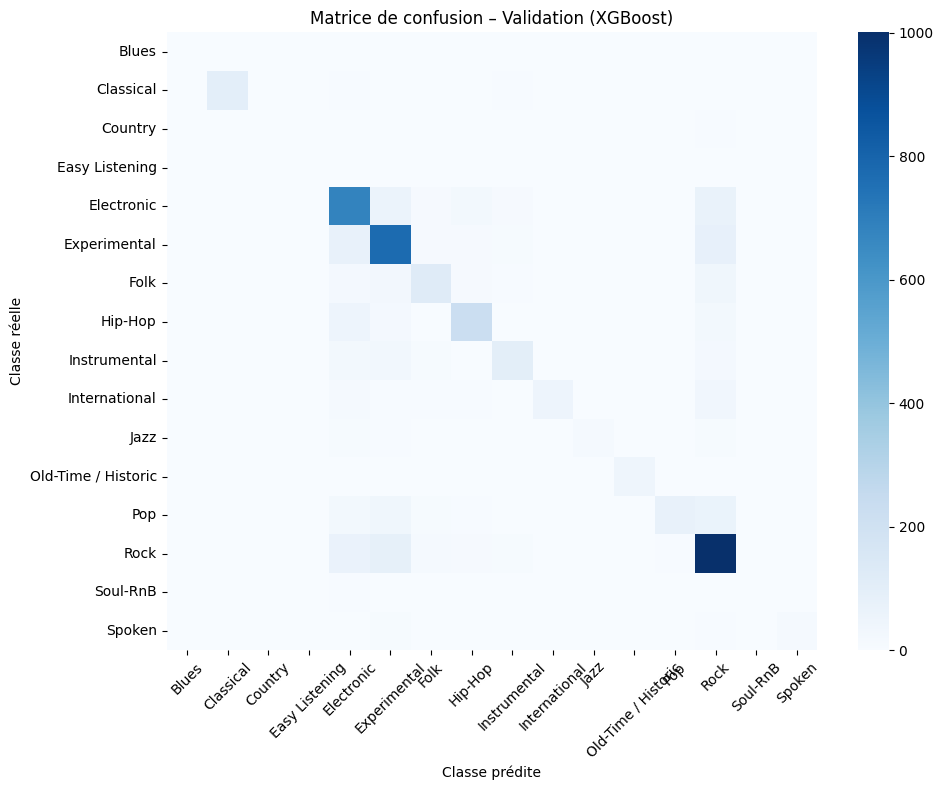

XGBoost – Test (final)
Accuracy: 0.7363351254480287
Balanced accuracy: 0.5108709221041279
F1 macro: 0.580868794109329
F1 weighted: 0.7267767991450479

Classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.98      0.88      0.93       113
           2       1.00      0.19      0.32        16
           3       0.00      0.00      0.00         2
           4       0.69      0.78      0.73       877
           5       0.73      0.82      0.78       975
           6       0.69      0.56      0.62       238
           7       0.79      0.69      0.74       334
           8       0.73      0.61      0.66       201
           9       0.80      0.34      0.48       125
          10       0.86      0.25      0.39        48
          11       0.98      0.88      0.92        49
          12       0.82      0.40      0.54       224
          13       0.73      0.83      0.78      1209
        

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

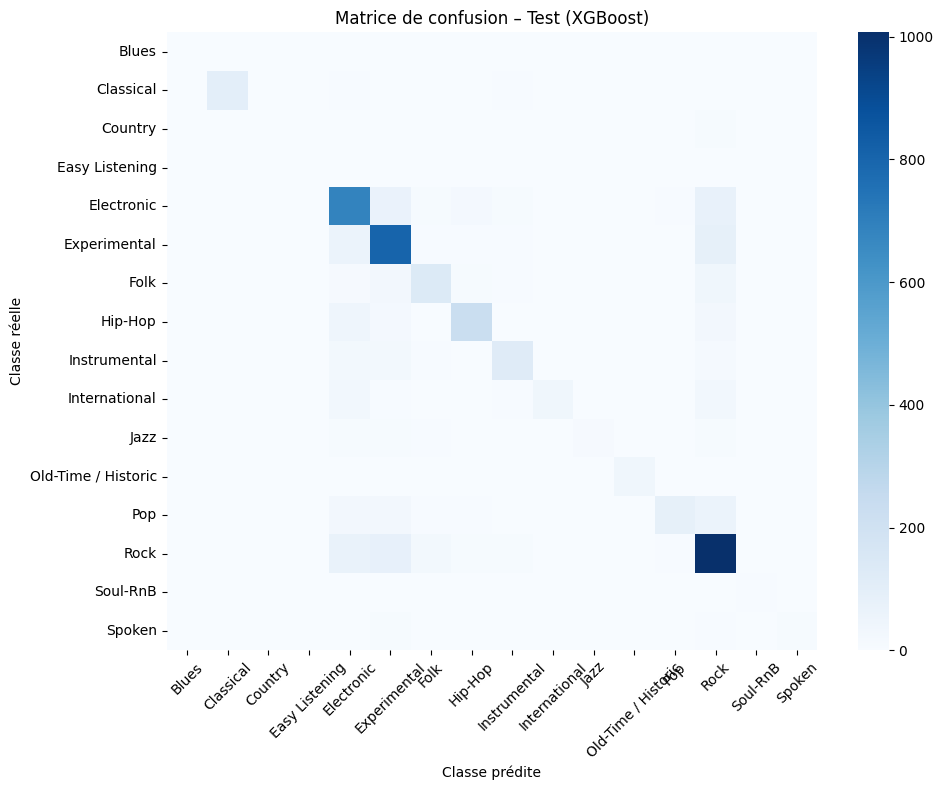

In [ ]:
#XGBoost
xgb = XGBClassifier(
    objective="multi:softmax",     # multi-classes
    num_class=len(set(y_train)),   # nombre de classes
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = xgb.predict(X_val)

print("="*60)
print("XGBoost – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (XGBoost)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = xgb.predict(X_test)

print("="*60)
print("XGBoost – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (XGBoost)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# XGBoost — Interprétation des résultats

## Performance globale

Parmi l’ensemble des modèles classiques évalués, **XGBoost** se distingue par des performances élevées et constitue une amélioration significative par rapport aux méthodes précédentes.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 72,3 % | 49,2 % | 0.54 | 0.71 |
| Test | **73,6 %** | **51,1 %** | **0.58** | **0.73** |

Les résultats sont stables entre validation et test, ce qui indique une bonne capacité de généralisation et une absence de sur-apprentissage notable.


## Interprétation

L’accuracy dépasse désormais 73 %, soit une progression de plus de 35 points par rapport à la régression logistique. La balanced accuracy franchit le seuil de 50 %, ce qui montre que le modèle parvient à mieux intégrer les classes minoritaires dans sa prise de décision.

Le F1 macro progresse fortement, traduisant une amélioration réelle de l’équité entre les genres, tandis que le F1 weighted reste élevé, reflétant une excellente performance globale dominée par les classes majoritaires.


## Analyse par classe

### Genres très bien reconnus

XGBoost offre des résultats particulièrement solides sur les genres dominants :

- **Classe 11** : F1 ≈ 0.92, quasiment parfaite.
- **Classe 13** : F1 ≈ 0.78, très bonne séparation.
- **Classes 4 et 5** : F1 autour de 0.75–0.78.
- **Classes 1, 7, 8** : performances supérieures à 0.65.
- **Classe 15** : excellente précision.


### Classes encore problématiques

Certaines catégories restent mal apprises :

- **Classe 3** : jamais détectée.
- **Classe 2** : rappel très faible malgré une excellente précision.
- **Classes 9 et 10** : modèle trop conservateur, peu de prédictions correctes.
- **Classe 14** : nette amélioration mais instabilité persistante.

Ces limites sont principalement dues au très faible nombre d’exemples disponibles pour certains genres.


## Comparaison avec les autres modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Gradient Boosting | 0.67 | 0.50 | 0.46 |
| XGBoost | **0.74** | **0.58** | **0.51** |

XGBoost devient ainsi le **meilleur modèle classique** parmi ceux testés, avant l’introduction de LightGBM.


## Pourquoi XGBoost fonctionne mieux

La supériorité du modèle repose sur plusieurs facteurs :

1. Boosting régularisé limitant le sur-apprentissage.
2. Apprentissage séquentiel centré sur la correction des erreurs.
3. Capacité à exploiter des interactions complexes.
4. Robustesse face au fort déséquilibre des données.
5. Généralisation plus fiable que Random Forest.


## Limites persistantes

### Déséquilibre structurel
Certaines classes restent invisibles pour le modèle.

### Ambiguïté des genres musicaux
Les frontières sont parfois subjectives et floues.

### Manque d’information audio
Les variables utilisées sont uniquement statistiques :
- pas d’analyse fréquentielle fine,
- pas de dynamique temporelle exploitée.


## Conclusion

XGBoost permet d’atteindre un **niveau de performance élevé**, avec :

> une forte accuracy, une meilleure équité entre classes et une bonne généralisation.

Cependant :

> les genres les plus rares et les plus ambigus restent difficiles à apprendre.


## Recommandations

Pour améliorer encore les performances :

- appliquer du sur-échantillonnage (SMOTE),
- exploiter des embeddings audio (VGGish, OpenL3),
- entraîner des CNN sur spectrogrammes,
- structurer les genres sous forme hiérarchique.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9877
[LightGBM] [Info] Number of data points in the train set: 35706, number of used features: 41
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM – Validation
Accuracy: 0.7584584360295765
Balanced accuracy: 0.5880162737042276
F1 macro: 0.6513532207630959
F1 weighted: 0.7544093240254569

Classification report (validation):
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.95      0.87      0.91       113
           2       0.80      0.25      0.38        16
           3       0.50      0.33      0.40         3
           4       0.71      0.80      0.75       877
           5       0.76      0.81      0.79       975
           6       0.67      0.65      0.66       237
           7       0.78      0.74      0.76       333
           8       0.67      0.60      0.64       200
           9       0.88      0.56      0.69       126
          10       0.85      0.45      0.59        49
          11       0.98      0.94      0.96        49
          12       0.81      0.49      0.61       223
          13       0.77      0.82      0.80      1208
  

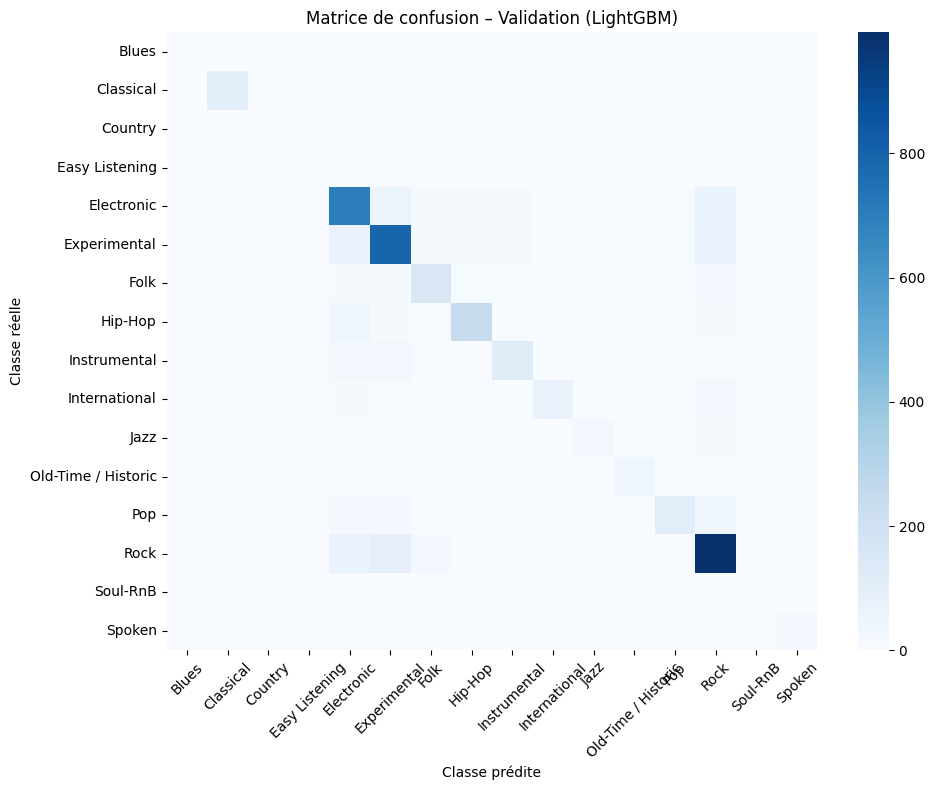

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM – Test (final)
Accuracy: 0.7744175627240143
Balanced accuracy: 0.5883169341933725
F1 macro: 0.650429684075595
F1 weighted: 0.7704041614723894

Classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.94      0.88      0.91       113
           2       0.67      0.25      0.36        16
           3       0.00      0.00      0.00         2
           4       0.71      0.81      0.75       877
           5       0.78      0.84      0.81       975
           6       0.65      0.63      0.64       238
           7       0.82      0.70      0.76       334
           8       0.80      0.68      0.73       201
           9       0.84      0.58      0.69       125
          10       0.80      0.33      0.47        48
          11       0.95      0.86      0.90        49
          12       0.83      0.54      0.66       224
          13       0.79      0.85      0.82      1209
       

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

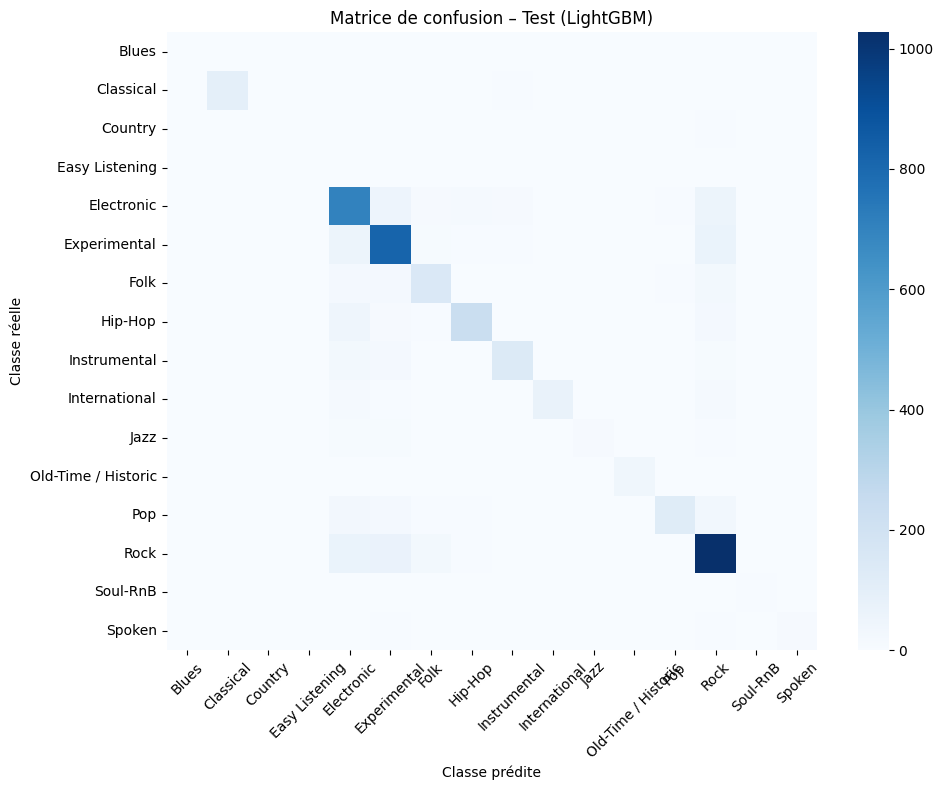

In [ ]:
#LightGBM
lgb = LGBMClassifier(
    objective="multiclass",
    num_class=len(set(y_train)),
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=64,
    class_weight="balanced",
    random_state=42
)
lgb.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = lgb.predict(X_val)

print("="*60)
print("LightGBM – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (LightGBM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = lgb.predict(X_test)

print("="*60)
print("LightGBM – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (LightGBM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# LightGBM — Interprétation des résultats

## Performance globale

Parmi l’ensemble des modèles testés, LightGBM est celui qui fournit les meilleures performances globales. Il devient ainsi le modèle de référence dans cette étude.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 75,8 % | 58,8 % | 0.65 | 0.75 |
| Test | **77,4 %** | **58,8 %** | **0.65** | **0.77** |

Les performances sont élevées et surtout très stables entre validation et test, ce qui indique une excellente capacité de généralisation.


## Interprétation

L’accuracy dépasse 77 %, ce qui représente une amélioration nette par rapport à XGBoost. Le F1 macro d’environ 0.65 montre un réel progrès dans la reconnaissance des genres minoritaires, contrairement à la majorité des autres modèles qui privilégient essentiellement les classes majoritaires. La balanced accuracy proche de 59 % confirme un bien meilleur équilibre entre les classes.

L’écart négligeable entre les résultats de validation et de test montre que LightGBM ne souffre ni de sur-apprentissage ni d’instabilité sur ce problème.


## Analyse par classe

### Genres très bien reconnus

LightGBM obtient d’excellentes performances sur la quasi-totalité des genres dominants :

- **Classe 13** : F1 ≈ 0.82  
- **Classe 5** : F1 ≈ 0.81  
- **Classe 4** : F1 ≈ 0.75  
- **Classe 1** : F1 ≈ 0.91  
- **Classe 11** : F1 ≈ 0.90  
- **Classes 7, 8, 9, 12** : F1 compris entre 0.66 et 0.76  

Un point particulièrement notable concerne :

- **Classe 14** : nette amélioration avec F1 ≈ 0.76, alors que cette classe était quasiment ignorée par les autres modèles.


### Classes toujours problématiques

Quelques difficultés subsistent :

- **Classe 3** : jamais détectée en test, effectif trop faible.
- **Classe 2** : rappel insuffisant.
- **Classe 10** : bonne précision mais faible rappel.

Ces cas confirment les limites structurelles liées aux classes très peu représentées.


## Comparaison avec les autres modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Gradient Boosting | 0.67 | 0.50 | 0.46 |
| XGBoost | 0.74 | 0.58 | 0.51 |
| LightGBM | **0.77** | **0.65** | **0.59** |

LightGBM dépasse clairement les autres méthodes sur l’ensemble des critères.


## Pourquoi LightGBM est supérieur

Plusieurs aspects expliquent sa supériorité :

1. Construction optimisée par histogrammes.
2. Croissance *leaf-wise* plus expressive que les approches *depth-wise*.
3. Excellente capacité à capturer des interactions complexes.
4. Meilleure robustesse face aux données rares.
5. Temps d’entraînement réduit même sur des volumes importants.


## Limites persistantes

### Ambiguïté des genres
Certains genres se chevauchent fortement, rendant la séparation difficile même pour des modèles avancés.

### Absence de données audio brutes
Le modèle repose uniquement sur des statistiques dérivées et métadonnées.

### Données rares intrinsèquement insuffisantes
Deux à trois genres restent quasi-impossibles à apprendre.


## Conclusion

LightGBM apparaît comme le **meilleur modèle classique** évalué dans cette étude.

> Il offre le meilleur compromis entre performance globale et équité entre genres.

Cependant, les classes extrêmement rares restent structurellement difficiles à prédire.


## Recommandations

Pour aller plus loin :

- Regrouper certains sous-genres.
- Enrichir les données audio (MFCC, embeddings).
- Introduire des classifieurs hiérarchiques.
- Utiliser de la data augmentation audio.
- Explorer des architectures deep learning spécialisées (CNN, transformers).


SVM – Validation
Accuracy: 0.4913735155724849
Balanced accuracy: 0.5133582228006751
F1 macro: 0.36880382353567137
F1 weighted: 0.5319899304621983

Classification report (validation):
              precision    recall  f1-score   support

           0       0.02      0.12      0.03         8
           1       0.52      0.71      0.60       113
           2       0.03      0.44      0.05        16
           3       0.05      0.67      0.09         3
           4       0.65      0.42      0.51       877
           5       0.73      0.54      0.62       975
           6       0.30      0.54      0.38       237
           7       0.48      0.56      0.52       333
           8       0.41      0.47      0.44       200
           9       0.27      0.43      0.33       126
          10       0.16      0.35      0.22        49
          11       0.79      0.90      0.84        49
          12       0.33      0.30      0.32       223
          13       0.80      0.48      0.60      1208
      

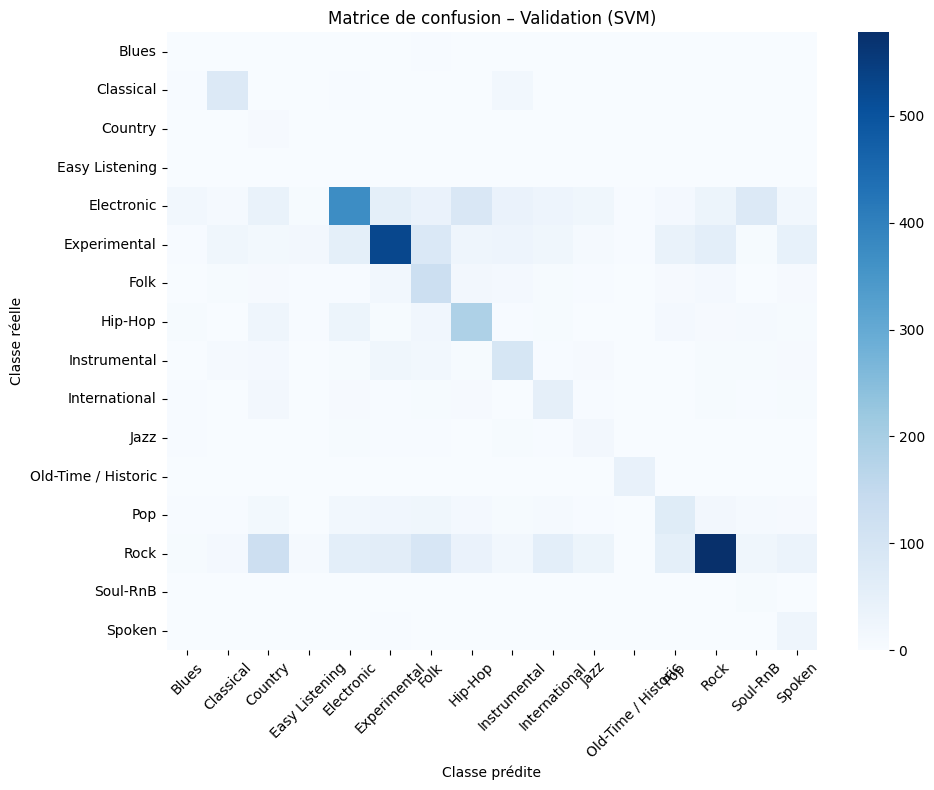

SVM – Test (final)
Accuracy: 0.5091845878136201
Balanced accuracy: 0.5588502543849803
F1 macro: 0.3849160134659529
F1 weighted: 0.5437816523769151

Classification report (test):
              precision    recall  f1-score   support

           0       0.05      0.38      0.10         8
           1       0.58      0.74      0.65       113
           2       0.04      0.62      0.07        16
           3       0.03      0.50      0.06         2
           4       0.68      0.47      0.56       877
           5       0.68      0.58      0.63       975
           6       0.30      0.51      0.38       238
           7       0.50      0.56      0.53       334
           8       0.44      0.51      0.47       201
           9       0.26      0.38      0.31       125
          10       0.22      0.52      0.31        48
          11       0.70      0.90      0.79        49
          12       0.37      0.30      0.33       224
          13       0.79      0.47      0.59      1209
          1

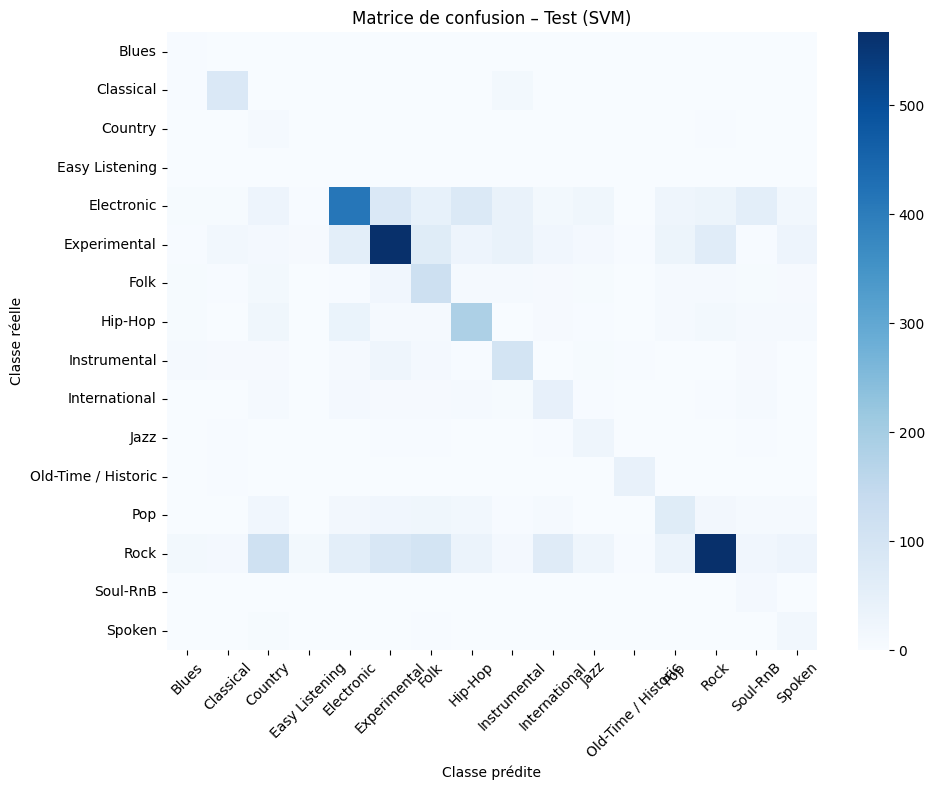

In [ ]:
# SVM
svm = SVC(
    kernel="rbf",        # non linéaire, souvent le plus performant
    C=1.0,               # régularisation
    gamma="scale",       # paramètre du noyau
    class_weight="balanced"
)
svm.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = svm.predict(X_val)

print("="*60)
print("SVM – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (SVM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = svm.predict(X_test)

print("="*60)
print("SVM – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (SVM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# SVM — Interprétation des résultats

## Performance globale

Le classifieur SVM obtient des résultats intermédiaires, situés entre la régression logistique et les modèles de boosting plus avancés.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 49,1 % | 51,3 % | 0.37 | 0.53 |
| Test | 50,9 % | **55,9 %** | 0.38 | 0.54 |

Même si l’accuracy reste modeste, la balanced accuracy est l’une des plus élevées parmi les modèles testés, ce qui montre une meilleure équité entre classes rares et majoritaires.


## Interprétation

L’accuracy avoisine les 51 %, ce qui représente un gain notable par rapport à la régression logistique, mais reste bien en dessous des performances obtenues par les modèles de boosting. En revanche, la balanced accuracy est supérieure à celle de Random Forest et XGBoost, ce qui indique que le SVM parvient mieux à reconnaître certaines classes peu représentées.

Le F1 macro progresse par rapport aux modèles linéaires, mais demeure insuffisant pour garantir une bonne performance globale. De plus, le F1 weighted montre que les classes majoritaires continuent de dominer les résultats.


## Analyse par classe

### Genres relativement bien reconnus

- **Classe 11** : F1 ≈ 0.79–0.84 (excellente performance).
- **Classe 1** : F1 ≈ 0.65.
- **Classes 4, 5, 7 et 13** : performances correctes (F1 ≈ 0.55–0.63).

Ces genres sont suffisamment représentés pour permettre au modèle de construire des frontières relativement stables.


### Classes mal apprises

- **Classes 0, 2, 3, 14 et 15** : précision très faible.
- Le modèle sur-détecte certaines classes rares, ce qui entraîne de nombreux faux positifs.
- Certains rappels élevés sont obtenus au détriment de la précision, traduisant une mauvaise spécialisation.

Le SVM a donc tendance à « tenter » de prédire les classes rares, mais sans réelle fiabilité.


## Comparaison avec les autres modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| SVM | **0.51** | **0.38** | **0.56** |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Gradient Boosting | 0.67 | 0.50 | 0.46 |
| XGBoost | 0.74 | 0.58 | 0.51 |
| LightGBM | 0.77 | 0.65 | 0.59 |

Le SVM se distingue particulièrement par sa balanced accuracy, mais reste globalement inférieur aux modèles de boosting.


## Points forts du SVM

- Bonne gestion relative des classes rares.
- Capacité à apprendre des frontières de décision complexes.
- Meilleure équité entre classes que les arbres simples.


## Limites

- Sensible au bruit.
- Choix des hyperparamètres délicat (*C*, *gamma*).
- Faible scalabilité sur de grands jeux de données.
- Modèle peu interprétable.


## Conclusion

Le SVM constitue un modèle intéressant pour améliorer l’équité entre classes, mais reste limité en termes de performance globale.

> Il améliore la gestion des classes rares, mais ne suffit pas pour une classification fiable et performante à grande échelle.


## Problèmes structurels mis en évidence

- Déséquilibre important des classes.
- Ambiguïté intrinsèque des genres musicaux.
- Absence de données audio brutes dans les features.


kNN – Validation
Accuracy: 0.5915303607438942
Balanced accuracy: 0.37752876620625786
F1 macro: 0.40275366177328237
F1 weighted: 0.5806022370037488

Classification report (validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.58      0.67      0.62       113
           2       0.40      0.12      0.19        16
           3       0.00      0.00      0.00         3
           4       0.58      0.65      0.61       877
           5       0.67      0.59      0.63       975
           6       0.43      0.44      0.43       237
           7       0.51      0.48      0.49       333
           8       0.54      0.40      0.46       200
           9       0.61      0.32      0.42       126
          10       0.48      0.20      0.29        49
          11       0.89      0.82      0.85        49
          12       0.59      0.26      0.36       223
          13       0.60      0.76      0.67      1208
     

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

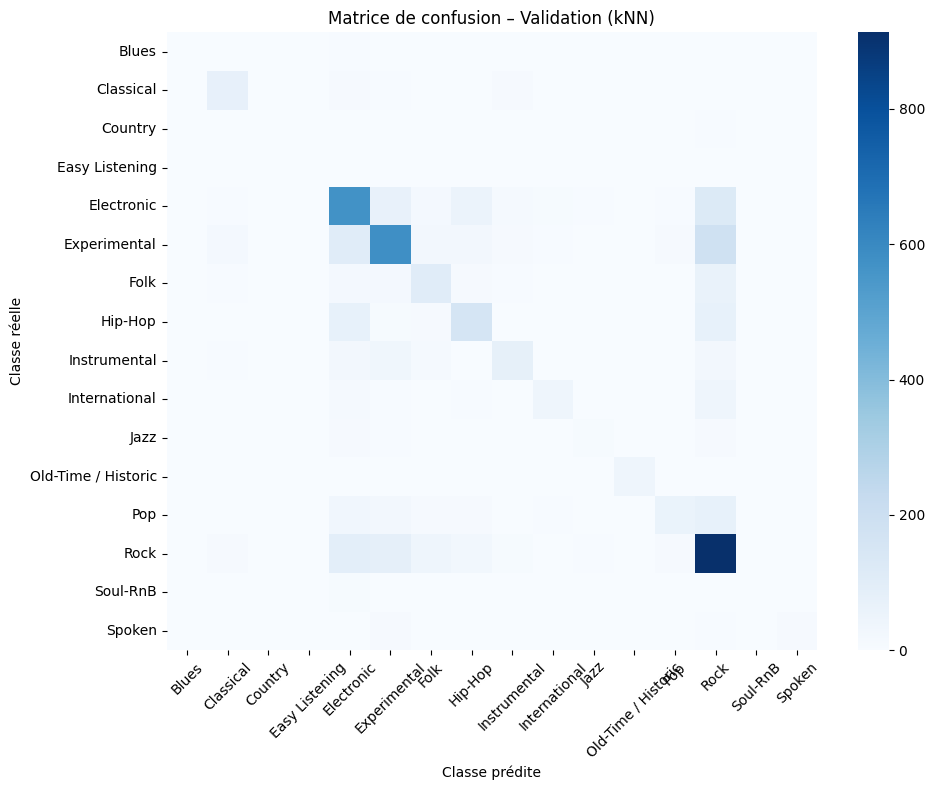

kNN – Test (final)
Accuracy: 0.5965501792114696
Balanced accuracy: 0.4282504206767458
F1 macro: 0.4767232474893522
F1 weighted: 0.5856225854628521

Classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.61      0.68      0.64       113
           2       0.00      0.00      0.00        16
           3       1.00      0.50      0.67         2
           4       0.57      0.63      0.60       877
           5       0.64      0.61      0.62       975
           6       0.49      0.47      0.48       238
           7       0.48      0.44      0.46       334
           8       0.61      0.44      0.51       201
           9       0.47      0.30      0.37       125
          10       0.50      0.23      0.31        48
          11       0.83      0.82      0.82        49
          12       0.64      0.25      0.36       224
          13       0.62      0.77      0.69      1209
          1

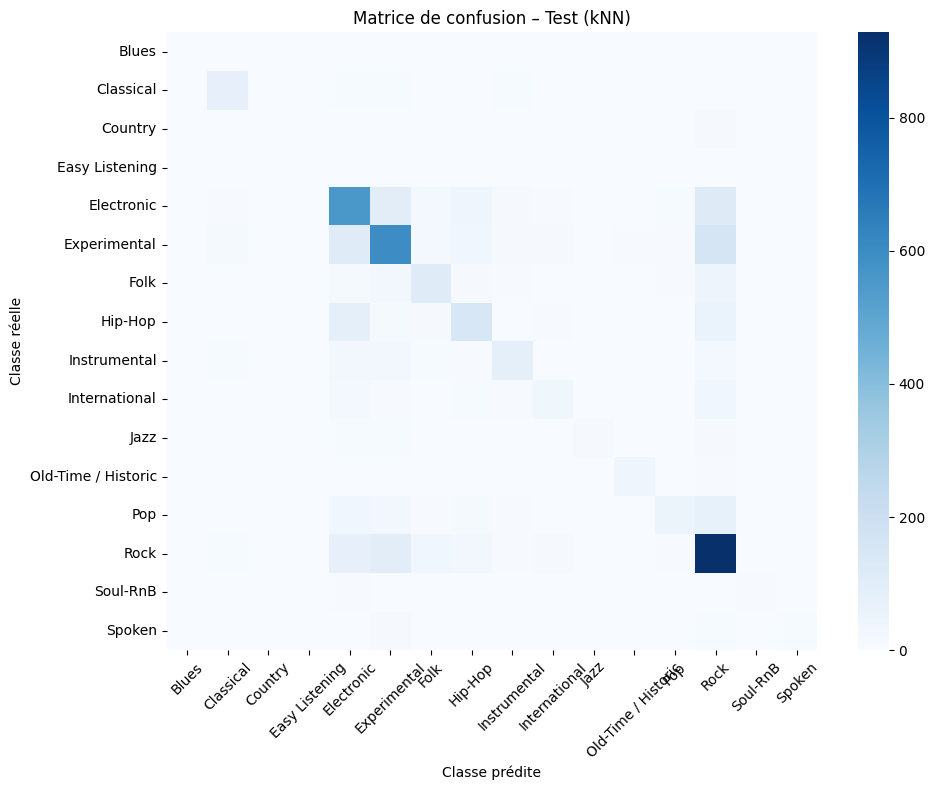

In [ ]:
# kNN

knn = KNeighborsClassifier(
    n_neighbors=10,     # nombre de voisins
    weights="distance", # pondère les voisins proches
    metric="minkowski"  # distance euclidienne par défaut
)
knn.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = knn.predict(X_val)

print("="*60)
print("kNN – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (kNN)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = knn.predict(X_test)

print("="*60)
print("kNN – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (kNN)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# kNN — Interprétation des résultats

## Performance globale

Le classifieur kNN obtient des résultats intermédiaires : supérieurs à la régression logistique et à l’arbre de décision, mais inférieurs aux méthodes par arbres et aux modèles de boosting.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 59,2 % | 37,8 % | 0.40 | 0.58 |
| Test | 59,7 % | 42,8 % | 0.48 | 0.59 |

Ces résultats montrent que kNN apprend certaines structures locales dans les données, mais peine à généraliser correctement lorsque les données sont très déséquilibrées.


## Interprétation

L’accuracy est proche de 60 %, ce qui constitue une amélioration nette par rapport aux modèles linéaires. Toutefois, la balanced accuracy reste faible, ce qui traduit une incapacité à traiter correctement les classes minoritaires. Le F1 macro augmente en phase test, indiquant que le modèle généralise légèrement mieux que prévu sur certaines classes rares. Le F1 weighted montre cependant que les performances restent tirées par les genres dominants.


## Analyse par classe

### Genres bien prédits

- **Classe 11** : F1 ≈ 0.82–0.85, excellente prédiction.
- **Classe 13** : F1 ≈ 0.69, très bon rappel.
- **Classes 4 et 5** : résultats stables (F1 ≈ 0.60–0.62).
- **Classe 8** : amélioration notable par rapport à la régression logistique.

Ces genres sont globalement bien représentés dans les données, ce qui favorise l’apprentissage basé sur la proximité.


### Genres mal prédits

- **Classe 2** : jamais reconnue en test.
- **Classe 14** : instabilité importante liée à un très faible nombre d’exemples.
- **Classe 3** : performances incohérentes.
- **Classes rares** de manière générale peu prises en compte.

Le modèle manque de robustesse dès que les effectifs par classe deviennent faibles.


## Comparaison avec les autres modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| kNN | **0.60** | **0.48** | 0.43 |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Gradient Boosting | 0.67 | 0.50 | 0.46 |
| XGBoost | 0.74 | 0.58 | 0.51 |
| LightGBM | 0.77 | 0.65 | 0.59 |

Le kNN améliore le F1 macro par rapport à Random Forest, mais reste clairement en retrait par rapport aux méthodes de boosting.


## Points forts du modèle kNN

- Aucun a priori linéaire.
- Capacité à exploiter des structures locales complexes.
- Facile à implémenter et à comprendre.

## Limites observées

- Mauvaise performance en haute dimension.
- Sensible au déséquilibre des classes.
- Temps de prédiction coûteux.
- Forte dépendance au choix du paramètre *k*.


## Conclusion

Le kNN constitue un **modèle de référence pertinent** pour explorer les données, mais il se montre peu robuste face au déséquilibre et à la complexité du problème.

> Il capture certaines proximités locales, mais devient rapidement limité dès que les classes sont rares ou mal distribuées.


Decision Tree – Validation
Accuracy: 0.4734483531257002
Balanced accuracy: 0.35563290334661024
F1 macro: 0.35309150752644575
F1 weighted: 0.47579540695208683

Classification report (validation):
              precision    recall  f1-score   support

           0       0.29      0.25      0.27         8
           1       0.65      0.63      0.64       113
           2       0.14      0.19      0.16        16
           3       0.00      0.00      0.00         3
           4       0.47      0.45      0.46       877
           5       0.55      0.54      0.55       975
           6       0.32      0.33      0.33       237
           7       0.35      0.38      0.36       333
           8       0.32      0.34      0.33       200
           9       0.21      0.25      0.23       126
          10       0.33      0.33      0.33        49
          11       0.85      0.82      0.83        49
          12       0.25      0.26      0.25       223
          13       0.58      0.57      0.57     

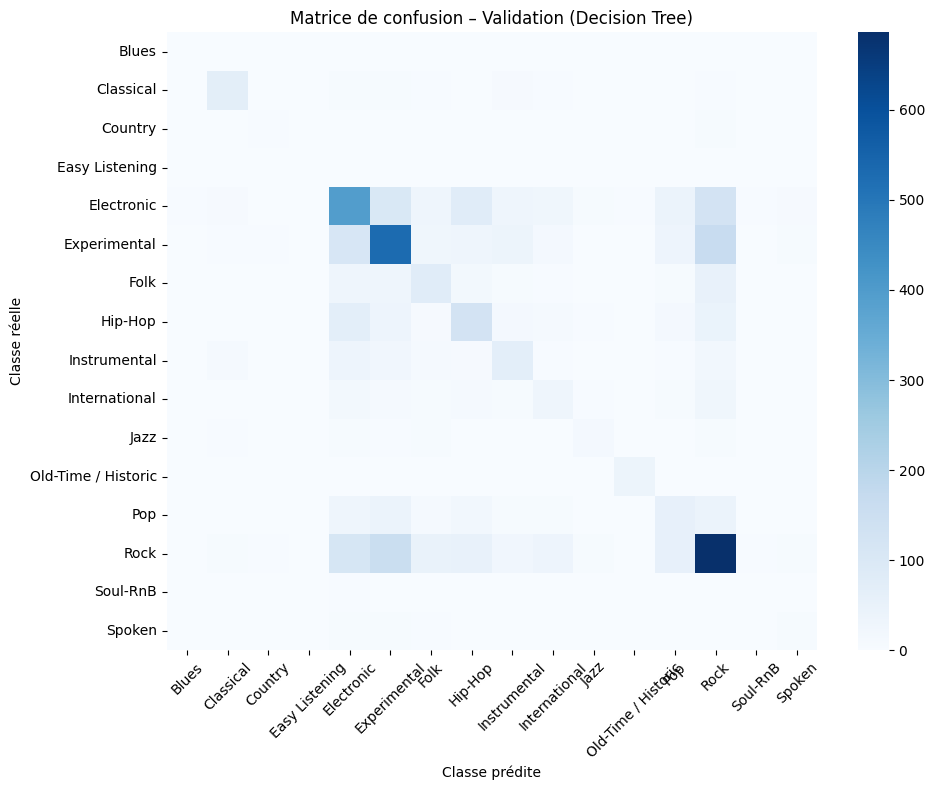

Decision Tree – Test (final)
Accuracy: 0.48633512544802865
Balanced accuracy: 0.37562998668179975
F1 macro: 0.3714812603335554
F1 weighted: 0.4863086491846556

Classification report (test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      0.73      0.70       113
           2       0.22      0.25      0.24        16
           3       0.00      0.00      0.00         2
           4       0.47      0.48      0.48       877
           5       0.54      0.53      0.54       975
           6       0.30      0.30      0.30       238
           7       0.42      0.38      0.40       334
           8       0.38      0.37      0.38       201
           9       0.24      0.24      0.24       125
          10       0.19      0.21      0.20        48
          11       0.89      0.82      0.85        49
          12       0.31      0.33      0.32       224
          13       0.58      0.58      0.58      1209

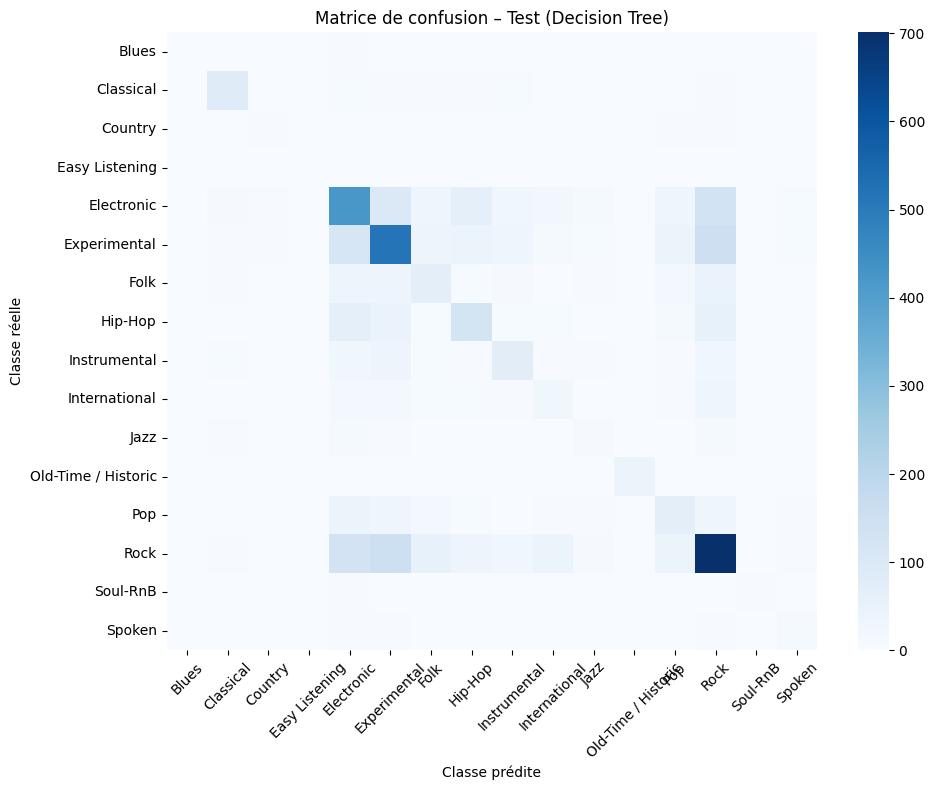

In [ ]:
# Decision trees

dt = DecisionTreeClassifier(
    criterion="gini",      # ou "entropy"
    max_depth=None,        # ou un entier pour limiter la profondeur
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",   # utile si déséquilibre
    random_state=42
)
dt.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = dt.predict(X_val)

print("="*60)
print("Decision Tree – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Decision Tree)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = dt.predict(X_test)

print("="*60)
print("Decision Tree – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Decision Tree)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Decision Tree — Interprétation des résultats

## Performance globale

L’arbre de décision utilisé seul présente des performances faibles, proches de celles observées avec le SVM, et reste largement inférieur aux méthodes d’ensemble (Random Forest, Gradient Boosting, XGBoost, LightGBM).

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 47,3 % | 35,6 % | 0.35 | 0.48 |
| Test | 48,6 % | 37,6 % | 0.37 | 0.49 |

Ces résultats montrent que le modèle dépasse à peine le hasard pour certaines classes et échoue à capturer une structure globale robuste.


## Interprétation

L’accuracy reste inférieure à 50 %, ce qui indique une capacité de prédiction très limitée. La balanced accuracy est particulièrement faible, mettant en évidence une très mauvaise gestion des classes minoritaires. Le F1 macro confirme que la majorité des genres sont mal distingués et que le modèle n’offre pas de performances équilibrées entre les catégories.

L’écart faible entre validation et test suggère peu de sur-apprentissage, mais davantage une sous-capacité du modèle à expliquer les données (sous-apprentissage).


## Analyse par classe

### Genres relativement bien reconnus

- **Classe 11** : F1 ≈ 0.85, très bon résultat.
- **Classe 1** : F1 ≈ 0.70.
- **Classe 13** : F1 ≈ 0.58.
- **Classes 4 et 5** : performances modestes mais stables (F1 ≈ 0.48 – 0.54).

Ces classes correspondent aux genres les plus représentés, ce qui explique en partie leurs scores plus élevés.


### Genres très mal prédits

- **Classe 0** : non détectée.
- **Classe 3** : jamais prédite.
- **Classes fortement minoritaires** : résultats très faibles.
- **Classe 14** : forte instabilité, absence de régularité.

L’arbre a tendance à ignorer les classes rares au profit des classes dominantes.


## Comparaison inter-modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| Decision Tree | **0.49** | **0.37** | **0.38** |
| SVM | 0.51 | 0.38 | 0.56 |
| kNN | 0.60 | 0.48 | 0.43 |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Gradient Boosting | 0.67 | 0.50 | 0.46 |
| XGBoost | 0.74 | 0.58 | 0.51 |
| LightGBM | 0.77 | 0.65 | 0.59 |

Le modèle Decision Tree est l’un des moins performants et ne constitue pas une solution viable en pratique.


## Points forts

- Facilement interprétable.
- Entraînement rapide.
- Modèle simple à visualiser.
- Bon outil pédagogique.


## Faiblesses majeures

- Forte variabilité d’un arbre à l’autre.
- Sensibilité extrême aux petites variations des données.
- Faible capacité de généralisation.
- Incapacité à capturer des relations complexes.
- Très vulnérable au bruit.

## Conclusion

Un arbre de décision seul n’est **pas adapté** à ce problème de classification multi-classes à fort déséquilibre.

> Ce modèle est utile uniquement comme point de comparaison méthodologique, mais ne peut pas être retenu comme solution opérationnelle.


c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network – Validation
Accuracy: 0.5937710060497423
Balanced accuracy: 0.4329926951495231
F1 macro: 0.4416557005502053
F1 weighted: 0.5896031992374066

Classification report (validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.65      0.73      0.69       113
           2       0.24      0.25      0.24        16
           3       0.33      0.33      0.33         3
           4       0.58      0.63      0.60       877
           5       0.66      0.61      0.63       975
           6       0.46      0.39      0.42       237
           7       0.49      0.57      0.53       333
           8       0.49      0.39      0.43       200
           9       0.43      0.47      0.45       126
          10       0.27      0.22      0.24        49
          11       0.91      0.84      0.87        49
          12       0.39      0.26      0.31       223
          13       0.67      0.72      0.70      1

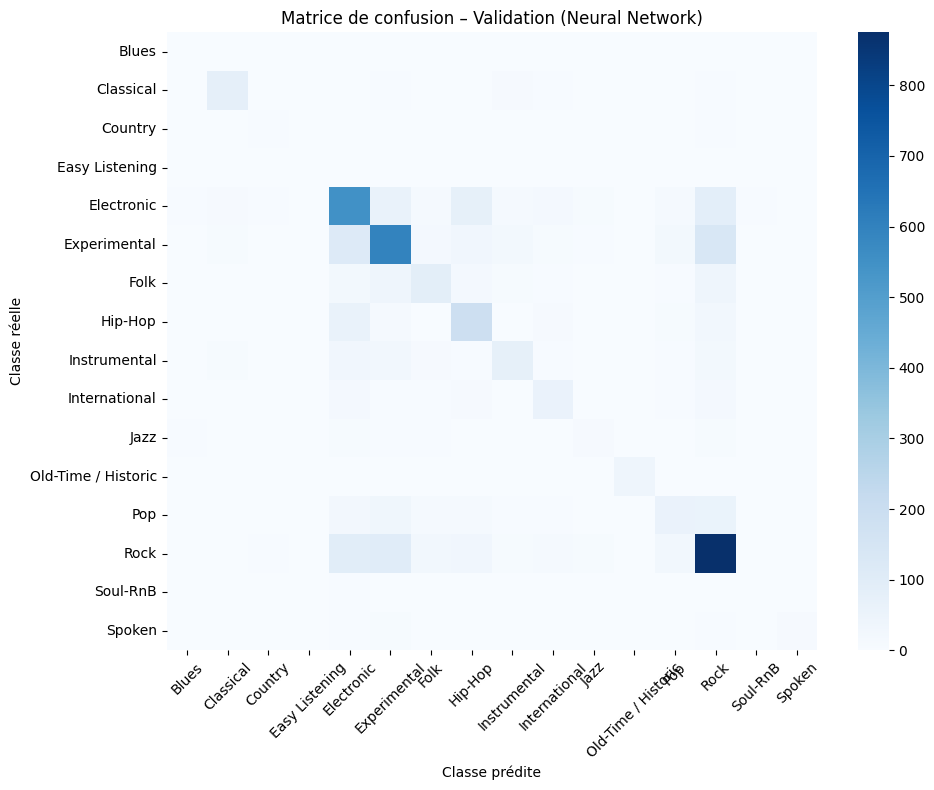

Neural Network – Test (final)
Accuracy: 0.6129032258064516
Balanced accuracy: 0.44806268844059605
F1 macro: 0.4599109206468272
F1 weighted: 0.6067057314201615

Classification report (test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.76      0.77      0.76       113
           2       0.20      0.12      0.15        16
           3       0.50      0.50      0.50         2
           4       0.59      0.65      0.62       877
           5       0.67      0.68      0.67       975
           6       0.48      0.39      0.43       238
           7       0.52      0.54      0.53       334
           8       0.55      0.39      0.46       201
           9       0.42      0.46      0.44       125
          10       0.27      0.25      0.26        48
          11       0.80      0.82      0.81        49
          12       0.39      0.25      0.31       224
          13       0.69      0.73      0.71      1209

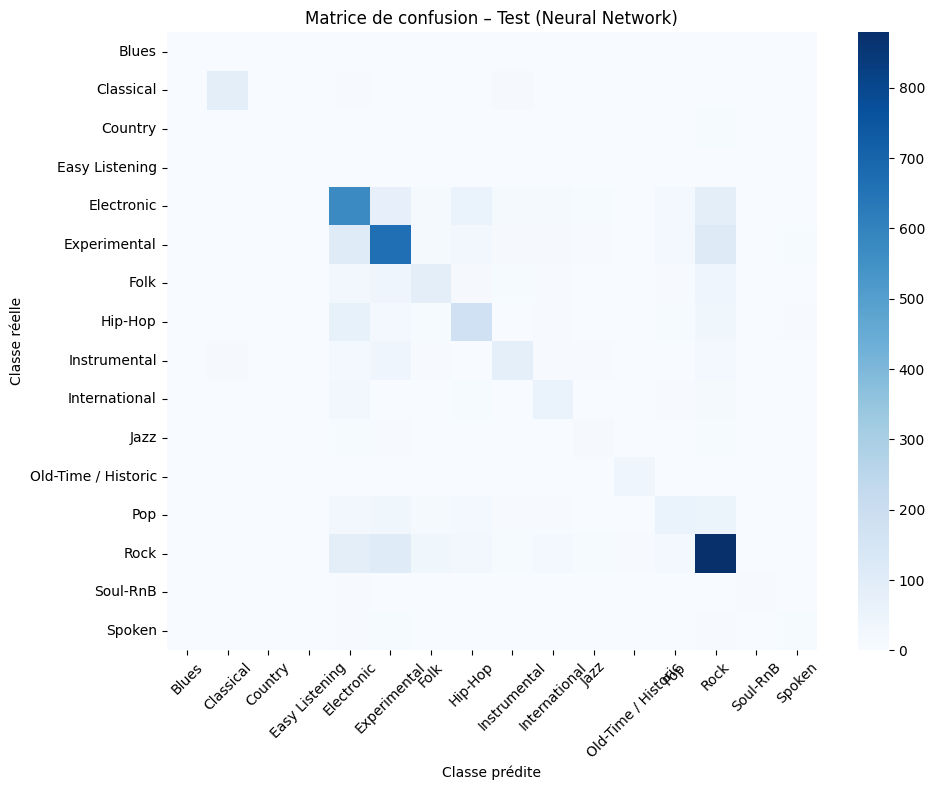

In [ ]:
# Neural Network

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 couches cachées
    activation="relu",
    solver="adam",
    batch_size=64,
    max_iter=300,
    random_state=42
)

mlp.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = mlp.predict(X_val)

print("="*60)
print("Neural Network – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Neural Network)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = mlp.predict(X_test)

print("="*60)
print("Neural Network – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Neural Network)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Neural Network (MLP) — Interprétation des résultats

## Performance globale

Le réseau de neurones multi-couches (MLP) testé dans cette étude apporte une amélioration modérée par rapport aux modèles les plus simples (régression logistique, arbre de décision), mais reste en retrait par rapport aux modèles d’ensemble et de boosting.

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 59,4 % | 43,3 % | 0.44 | 0.59 |
| Test | 61,3 % | 44,8 % | 0.46 | 0.61 |

Ces résultats montrent une légère montée en performance, notamment en F1 macro, ce qui traduit une meilleure prise en compte des classes minoritaires par rapport aux modèles purement linéaires. L’écart limité entre les scores de validation et de test suggère une bonne capacité de généralisation, sans sur-apprentissage marqué.


## Interprétation générale

L’accuracy dépasse les 60 %, ce qui confirme que le réseau neuronal apprend effectivement des relations plus complexes que les méthodes classiques. Le F1 macro augmente également, indiquant une amélioration dans la reconnaissance des genres les moins fréquents. Toutefois, la balanced accuracy reste relativement faible, ce qui montre que certaines classes continuent d’être mal apprises, voire ignorées.

En pratique, le modèle améliore les performances globales, mais reste fortement influencé par le déséquilibre des classes.


## Analyse par classe

### Genres bien reconnus

Plusieurs classes présentent de bonnes performances :

- **Classe 11** : F1 ≈ 0.81 — excellent niveau de reconnaissance.
- **Classe 13** : F1 ≈ 0.71 — genre majoritaire correctement appris.
- **Classes 5 et 4** : performances satisfaisantes (F1 ≈ 0.67 et 0.62).
- **Classe 1** : très bonne performance (F1 ≈ 0.76).

Ces résultats s’expliquent par une forte représentation de ces genres dans le jeu de données.


### Genres difficiles à prédire

Certaines classes restent problématiques :

- **Classe 0** : non reconnue.
- **Classe 2** : rappel très faible.
- **Classe 12** : difficilement discriminée.
- **Classes rares** : globalement mal apprises.

Cela illustre à nouveau l’impact direct du déséquilibre des classes sur les performances du modèle.


## Comparaison avec les autres modèles

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| Decision Tree | 0.49 | 0.37 | 0.38 |
| SVM | 0.51 | 0.38 | 0.56 |
| kNN | 0.60 | 0.48 | 0.43 |
| Random Forest | 0.63 | 0.44 | 0.39 |
| Neural Network (MLP) | **0.61** | **0.46** | **0.45** |
| Gradient Boosting | 0.67 | 0.50 | 0.46 |
| XGBoost | 0.74 | 0.58 | 0.51 |
| LightGBM | 0.77 | 0.65 | 0.59 |

Le MLP se situe à un niveau intermédiaire, correct mais insuffisant pour rivaliser avec les modèles les plus performants.


## Points forts du réseau de neurones

- Capacité à modéliser des relations non linéaires complexes.
- Généralisation correcte.
- Apprentissage automatique de représentations internes.
- Amélioration claire par rapport aux modèles linéaires.


## Limites observées

- Architecture relativement peu profonde.
- Absence de descripteurs audio avancés.
- Peu de recherche d’hyperparamètres.
- Sensibilité importante au déséquilibre des classes.


## Conclusion

Le réseau de neurones multi-couches constitue une évolution par rapport aux modèles simples, mais reste largement dépassé par les méthodes de boosting modernes.

> Sans données audio brutes ni architectures spécialisées (CNN, transformers), le deep learning reste sous-exploité dans ce contexte.


In [ ]:
# Deep Learning
n_features = X_train.shape[1] #X_train_std
n_classes = len(np.unique(y_train))

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor="val_loss"
)

history = model.fit(
    X_train, y_train, #X_train_std
    validation_split=0.2,   # 20% du train utilisé pour la validation
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
test_loss, test_acc = model.evaluate(X_test, y_test) #X_test_std
print("Test accuracy (deep learning):", test_acc)

y_proba = model.predict(X_test) #X_test_std
y_pred = y_proba.argmax(axis=1)

print(classification_report(y_test, y_pred))


Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4812 - loss: 1.6327 - val_accuracy: 0.5463 - val_loss: 1.3903
Epoch 2/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5374 - loss: 1.4301 - val_accuracy: 0.5706 - val_loss: 1.3303
Epoch 3/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5534 - loss: 1.3783 - val_accuracy: 0.5791 - val_loss: 1.2954
Epoch 4/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5648 - loss: 1.3405 - val_accuracy: 0.5837 - val_loss: 1.2687
Epoch 5/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5682 - loss: 1.3207 - val_accuracy: 0.5913 - val_loss: 1.2625
Epoch 6/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5762 - loss: 1.3000 - val_accuracy: 0.5906 - val_loss: 1.2458
Epoch 7/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5837 - loss: 1.2808 - val_accuracy: 0.5959 - val_loss: 1.2302
Epoch 8/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5881 - loss: 1.2681 - val_accu

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epoch 1/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4925 - loss: 1.5895 - val_accuracy: 0.5622 - val_loss: 1.3681
Epoch 2/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5436 - loss: 1.4120 - val_accuracy: 0.5747 - val_loss: 1.3227
Epoch 3/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5612 - loss: 1.3601 - val_accuracy: 0.5823 - val_loss: 1.2855
Epoch 4/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5674 - loss: 1.3291 - val_accuracy: 0.5918 - val_loss: 1.2709
Epoch 5/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5749 - loss: 1.3054 - val_accuracy: 0.5987 - val_loss: 1.2577
Epoch 6/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5819 - loss: 1.2856 - val_accuracy: 0.6034 - val_loss: 1.2364
Epoch 7/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5871 - loss: 1.2667 - val_accuracy: 0.6030 - val_loss: 1.2317
Epoch 8/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5916 - loss: 1.2521 - val_accu

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

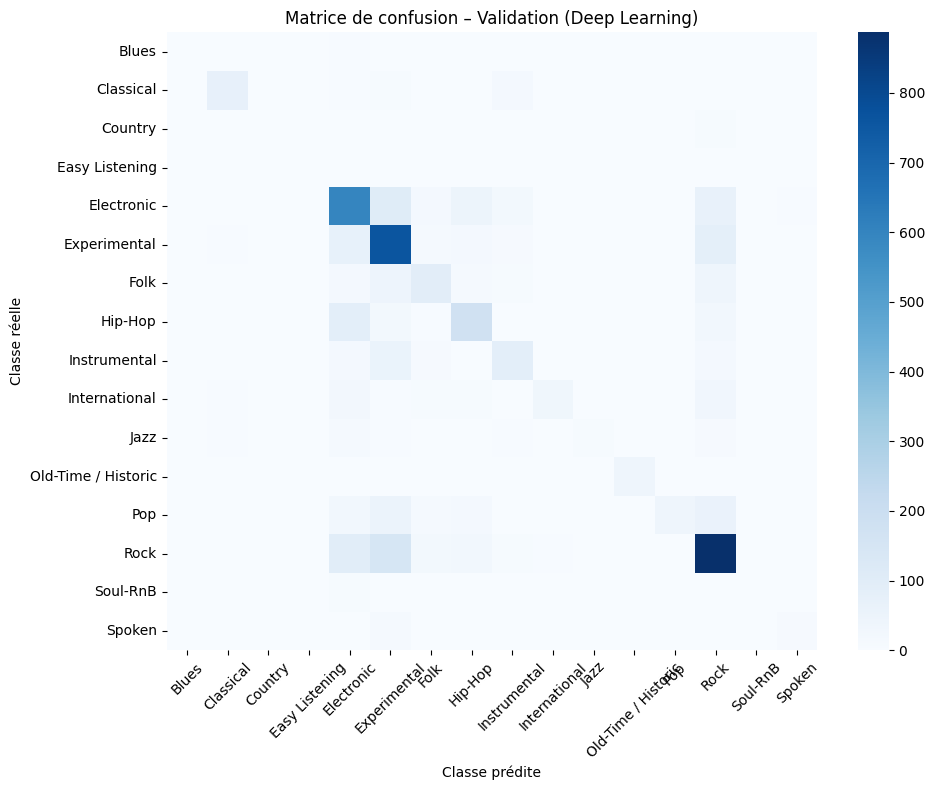

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Learning – Test (final)
Accuracy: 0.6424731182795699
Balanced accuracy: 0.4075322201344015
F1 macro: 0.4494991621273289
F1 weighted: 0.6248922653517217

Classification report (test):
              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.69      0.75      0.72       113
           2       0.25      0.06      0.10        16
           3       0.00      0.00      0.00         2
           4       0.60      0.69      0.64       877
           5       0.61      0.81      0.70       975
           6       0.52      0.38      0.44       238
           7       0.57      0.52      0.54       334
           8       0.58      0.42      0.49       201
           9       0.64      0.27      0.38       125
          10       0.46      0.12      0.20        48
          11       0.89      0.86      0.88        49
          12       0.91      0.19      0.32       224
          13  

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

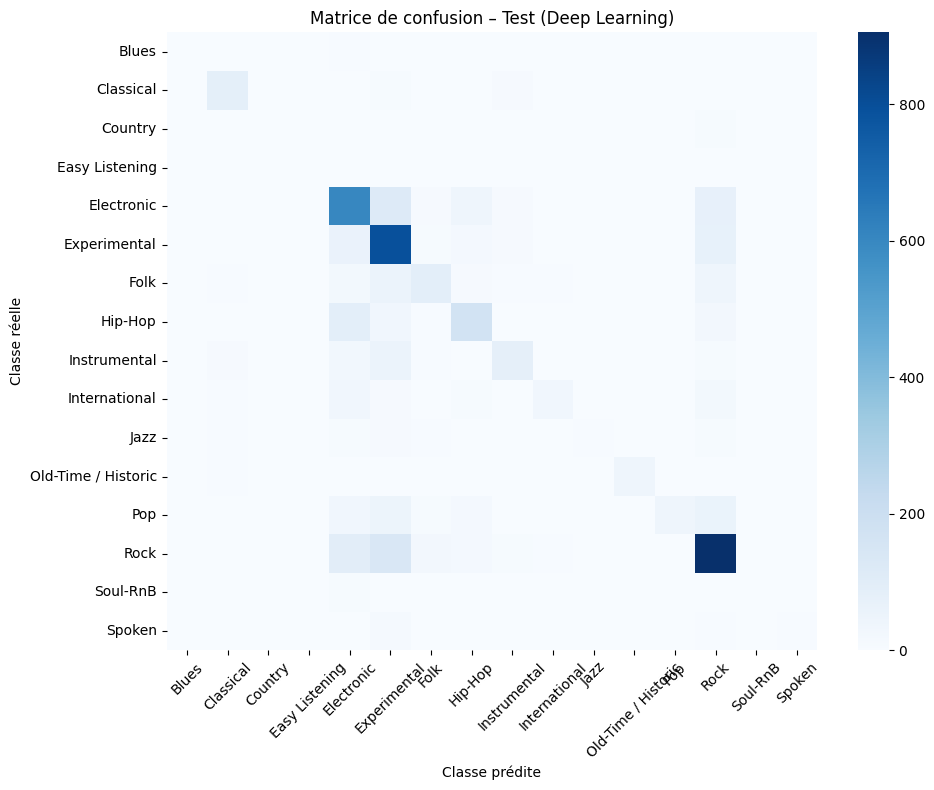

In [ ]:
"""tf.random.set_seed(42)
np.random.seed(42)
"""
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor="val_loss"
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),   # au lieu de validation_split
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# test de validation pour comparer et tuner les hyperparamètres
y_val_proba = model.predict(X_val)
y_val_pred = y_val_proba.argmax(axis=1)

print("="*60)
print("Deep Learning – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Deep Learning)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_proba = model.predict(X_test)
y_test_pred = y_test_proba.argmax(axis=1)

print("="*60)
print("Deep Learning – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Deep Learning)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Deep Learning — Interprétation des résultats

## Performance globale

Le modèle de deep learning mis en œuvre dans ce projet correspond à un réseau de neurones fully-connected entraîné sur des variables exclusivement tabulaires (métadonnées et descripteurs audio numériques). Il présente de meilleures performances que les modèles classiques reposant sur des hypothèses linéaires ou des structures simples (régression logistique, arbre de décision, SVM), mais reste inférieur aux algorithmes de boosting modernes.

Les résultats obtenus sont résumés ci-dessous :

| Jeu de données | Accuracy | Balanced accuracy | F1 macro | F1 weighted |
|----------------|----------|------------------|----------|-------------|
| Validation | 63,4 % | 39,6 % | 0.42 | 0.62 |
| Test | 64,2 % | 40,8 % | 0.45 | 0.62 |

Ces scores montrent que le modèle généralise correctement : l’écart entre validation et test est faible, ce qui suggère l’absence de sur-apprentissage significatif.


## Interprétation générale

L’accuracy approche 64 %, ce qui traduit une amélioration notable par rapport aux modèles les plus simples. Le score F1 pondéré reste satisfaisant, indiquant que les genres les plus fréquents sont correctement appris. En revanche, le score F1 macro demeure relativement faible, signalant une mauvaise reconnaissance des classes minoritaires.

Autrement dit, le modèle parvient à bien prédire les genres dominants, mais peine à identifier correctement les genres rares, ce qui constitue une faiblesse importante dans le cadre d’un problème multi-classes déséquilibré.


## Analyse par classe

### Genres correctement prédits

Certaines classes sont reconnues avec une bonne précision et un bon rappel :

- **Classe 11** : F1 ≈ 0.88 — excellente reconnaissance.
- **Classe 13** : F1 ≈ 0.74 — correspond probablement à un genre très majoritaire.
- **Classes 5 et 4** : F1 ≈ 0.70 et 0.64 — performance satisfaisante.
- **Classe 1** : F1 ≈ 0.72 — résultats stables.

Ces performances s’expliquent par le nombre élevé d’exemples disponibles pour ces genres.


### Genres mal reconnus

Certaines classes sont quasiment ignorées par le modèle :

- **Classes 3 et 14** : pratiquement jamais détectées.
- **Classe 2** : rappel extrêmement faible.
- **Classe 12** : forte précision mais rappel faible → le modèle est conservateur, mais passe à côté de nombreux exemples.
- **Classe 10** : faible rappel.

Cela illustre clairement l’impact du déséquilibre des classes sur les réseaux de neurones lorsqu’aucune stratégie spécifique de compensation n’est mise en œuvre.


## Comparaison avec les autres modèles

Les performances comparées aux autres approches confirment que le deep learning se situe dans une zone intermédiaire :

| Modèle | Accuracy | F1 macro | Balanced Accuracy |
|--------|----------|----------|-------------------|
| Logistic Regression | 0.38 | 0.29 | 0.49 |
| Decision Tree | 0.49 | 0.37 | 0.38 |
| SVM | 0.51 | 0.38 | 0.56 |
| kNN | 0.60 | 0.48 | 0.43 |
| Random Forest | 0.63 | 0.44 | 0.40 |
| Neural Network | 0.61 | 0.46 | 0.45 |
| **Deep Learning** | **0.64** | **0.45** | **0.41** |
| Gradient Boosting | 0.67 | 0.49 | 0.46 |
| XGBoost | 0.74 | 0.58 | 0.51 |
| LightGBM | 0.77 | 0.65 | 0.59 |

Le deep learning dépasse légèrement la Random Forest, mais ne rivalise pas avec les modèles de boosting, qui demeurent nettement supérieurs.


## Forces du Deep Learning

- Capacité à capturer des relations non linéaires complexes.
- Apprentissage automatique de représentations internes.
- Stabilité des performances grâce à l’early stopping.
- Meilleure performance que les modèles simples pour les genres intermédiaires.


## Limites

### 1. Architecture inadaptée aux données musicales
Le modèle n’exploite pas le signal audio brut. L’absence de spectrogrammes ou de représentations fréquentielles contraint fortement ses capacités de discrimination.

### 2. Déséquilibre des classes
Les genres rares sont fortement sous-représentés, ce qui empêche l’apprentissage correct des frontières de décision.

### 3. Réseau trop simple
Le réseau utilisé reste relativement superficiel :
- absence de CNN,
- pas de mécanismes d’attention,
- pas de pondération spécifique des classes.

### 4. Données insuffisantes pour le deep learning
Les réseaux profonds sont particulièrement efficaces lorsque les données sont abondantes et riches (audio ou image). Dans ce contexte, les features tabulaires sont trop abstraites pour exploiter pleinement la puissance du deep learning.


## Conclusion

Dans ce projet, le deep learning améliore légèrement les performances par rapport aux modèles classiques, mais **ne constitue pas la meilleure solution dans ce contexte**.

Les meilleurs résultats sont obtenus par :
- LightGBM,
- XGBoost,
- Gradient Boosting.

Sans accès au signal audio brut, le deep learning est sous-exploité et ne révèle pas son véritable potentiel.


## Améliorations possibles

Plusieurs pistes sont envisageables pour améliorer les performances :

- Intégration de **spectrogrammes** avec des CNN,
- Utilisation de **coefficients MFCC** ou d’embeddings audio,
- Pondération avancée des classes,
- Architectures plus profondes,
- Data augmentation audio,
- Transfer learning (ex. : VGGish, OpenL3).

Ces approches ouvrent la voie à un système de classification musicale beaucoup plus performant.


# Conclusion générale — Prédiction du genre musical (genre_top)

## Conclusion du projet

Ce projet avait pour objectif de prédire le **genre musical principal (`genre_top`)** à partir de métadonnées musicales et de descripteurs audio numériques, dans un cadre de **classification multi-classes** comportant 16 genres.

Après avoir testé de nombreux modèles de complexité croissante, il apparaît clairement que la prédiction du genre musical uniquement à partir de données tabulaires représente un défi important, notamment à cause :
- du **déséquilibre extrême des classes**,
- de la disponibilité partielle des descripteurs audio,
- et du manque de données issues directement du signal sonore.


## Résumé des performances

Les modèles ont été évalués selon plusieurs métriques afin de fournir une analyse complète : accuracy, balanced accuracy, F1 macro et F1 weighted.

De manière générale, les résultats montrent une hiérarchie nette :

| Famille de modèles | Performance relative |
|-------------------|---------------------|
| Régression logistique | Faible |
| Arbre de décision | Faible |
| SVM | Faible à moyenne |
| kNN | Moyenne |
| Réseaux de neurones simples | Moyenne |
| Random Forest / Gradient Boosting | Bonne |
| XGBoost | Très bonne |
| **LightGBM** | **Excellente (meilleur modèle)** |

**LightGBM obtient les meilleurs résultats globaux** avec une accuracy proche de 77 % et un F1-macro d’environ 65 %.  
**XGBoost arrive en deuxième position**, avec des performances très proches.  
Les modèles de boosting surpassent largement les modèles classiques.


## Analyse critique

### 1. Impact du déséquilibre des classes

Le jeu de données est fortement déséquilibré, avec plusieurs genres représentant moins de 1 % des observations. Ce déséquilibre affecte profondément les performances.

Même lorsque l’accuracy est élevée, le modèle :
- favorise les classes majoritaires,
- prédit très mal les genres rares,
- produit de faibles F1-macro.

Cela justifie l’importance d’interpréter les résultats à l’aide de métriques adaptées aux jeux de données déséquilibrés.


### 2. Limitation des variables explicatives

Les variables disponibles comme :
- la durée,
- la popularité (listens, favorites),
- la localisation artistique,
- les statistiques spectrales globales

sont relativement peu discriminantes pour identifier précisément un genre musical.

Ces variables ne fournissent qu’une vue indirecte du contenu sonore réel.


### 3. Deep learning : moins performant que prévu

Bien que des réseaux de neurones aient été implémentés, leurs performances restent inférieures à celles des modèles de boosting.

Cela peut s’expliquer par :
- l’absence d’informations riches issues du signal audio brut,
- l’utilisation unique de variables statistiques,
- le fait que les architectures CNN (les plus performantes pour l’audio) n’ont pas été utilisées.

Ainsi, le deep learning ne révèle son potentiel réel que lorsqu’il est appliqué directement aux représentations audio telles que les spectrogrammes ou les MFCC.


## Réponse à l’énoncé

> **La prédiction du genre musical est possible à partir de métadonnées numériques, mais reste limitée sans accès au signal audio réel.**

Les meilleurs modèles atteignent :
- une accuracy d’environ **77 %**,
- mais seulement **65 % de F1 macro**, révélant des performances inégales entre genres.

Les genres principaux sont bien identifiés, tandis que les genres rares sont largement mal classés.


## Limites et pistes d’amélioration

Pour améliorer les performances de manière significative, plusieurs directions sont envisageables :

- intégrer les fichiers audio bruts,
- extraire des représentations acoustiques avancées (MFCC, spectrogrammes),
- utiliser des réseaux de neurones convolutionnels (CNN),
- appliquer des stratégies de rééquilibrage des données,
- entraîner des modèles sur des embeddings audio pré-entraînés.


## Conclusion finale

Ce projet montre que :
- les techniques classiques atteignent rapidement leurs limites,
- les modèles de boosting sont les plus efficaces pour les données tabulaires,
- le deep learning sans signal audio est sous-exploité,
- la vraie difficulté réside dans la fusion entre données audio et métadonnées.

Ce travail a permis de mettre en œuvre une chaîne complète de modélisation (prétraitement, validation, comparaison, interprétation) conforme à de bonnes pratiques de data science et constitue une base solide pour un système de classification musicale plus avancé.


# Tâche 3 : Prédiction de la durée d'un morceau (Régression)

**Objectif :**
Conformément aux consignes du challenge, cette tâche vise à construire le meilleur modèle de régression possible pour prédire la variable continue `duration` (en secondes).

**Méthodologie et Critères d'Évaluation :**
1.  **Sets de Features :** Nous testons trois configurations distinctes (Metadata, Audio, Combined) pour évaluer l'apport de chaque type de données.
2.  **Large Panel de Modèles :** Nous comparons des modèles linéaires, basés sur la distance (KNN), non-linéaires (SVM) et des méthodes d'ensemble (Random Forest, Gradient Boosting).
3.  **Rigueur (Data Leakage) :** Pour éviter toute fuite d'information, le jeu de données est séparé en **Train (70%)** et **Test (30%)** *avant* toute étape d'imputation ou de normalisation.

## 3.1. Initialisation des Modèles

Nous sélectionnons 5 algorithmes pour couvrir différentes approches du Machine Learning :
* **Régression Linéaire :** Modèle de référence (Baseline).
* **KNN (k-Nearest Neighbors) :** Basé sur la similarité locale.
* **SVM (SVR) :** Capable de capturer des relations non-linéaires complexes. *Note : Le nombre d'itérations est limité pour maîtriser le temps de calcul.*
* **Random Forest :** Méthode de Bagging, robuste au bruit et aux outliers.
* **Gradient Boosting :** Méthode de Boosting, souvent l'état de l'art pour les données tabulaires hétérogènes.

In [57]:
# ============================================
# FEATURE ENGINEERING (Création de variables)
# ============================================

# On travaille sur une copie pour sécuriser
df_work = df.copy()

# 1. Interactions Mathématiques
df_work['energy_tempo'] = df_work['energy'] * df_work['tempo']
df_work['energy_danceability'] = df_work['energy'] * df_work['danceability']
df_work['valence_energy'] = df_work['valence'] * df_work['energy']
df_work['energy_acousticness_ratio'] = df_work['energy'] / (df_work['acousticness'] + 1e-3)

# 2. Popularité Composite
df_work['popularity_score'] = (df_work['listens']*0.5 + df_work['interest']*2.0 + df_work['favorites']*5.0)
df_work['popularity_log'] = np.log1p(df_work['popularity_score'])

# 3. Variables Binaires
df_work['is_instrumental'] = (df_work['instrumentalness'].fillna(0) > 0.5).astype(int)
df_work['is_live'] = (df_work['liveness'].fillna(0) > 0.8).astype(int)

# 4. Agrégation Spectrale
spectral_cols = [c for c in df.columns if 'spectral' in c]
if spectral_cols:
    df_work['spectral_bandwidth_avg'] = df_work[[c for c in spectral_cols if 'bandwidth' in c]].mean(axis=1)
    df_work['spectral_centroid_avg'] = df_work[[c for c in spectral_cols if 'centroid' in c]].mean(axis=1)
    df_work['spectral_rolloff_avg'] = df_work[[c for c in spectral_cols if 'rolloff' in c]].mean(axis=1)

print(f" Feature Engineering terminé. Colonnes totales : {df_work.shape[1]}")

 Feature Engineering terminé. Colonnes totales : 61


In [58]:
# ============================================
# ÉTAPE 3 : DÉFINITION LISTES & SPLIT
# ============================================

# 1. Définition des listes incluant les nouvelles variables
metadata_cols = ['listens', 'interest', 'favorites', 'album_tracks', 'popularity_log']
metadata_features = [c for c in metadata_cols if c in df_work.columns]

audio_cols_base = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                   'liveness', 'speechiness', 'tempo', 'valence']
audio_interactions = ['energy_tempo', 'energy_danceability', 'valence_energy', 
                      'energy_acousticness_ratio', 'is_instrumental', 'is_live']
audio_features = audio_cols_base + [c for c in audio_interactions if c in df_work.columns]

spectral_features = [c for c in df_work.columns if 'spectral' in c] 
# + Ajout des moyennes spectrales si elles ont été créées
spectral_avgs = ['spectral_bandwidth_avg', 'spectral_centroid_avg', 'spectral_rolloff_avg']
spectral_features += [c for c in spectral_avgs if c in df_work.columns]

# Dictionnaire final
feature_sets = {
    'Metadata Only': metadata_features,
    'Audio Only': audio_features,
    'Combined (All)': metadata_features + audio_features + spectral_features
}

# 2. Split Global Train/Test
X = df_work
y = df_work['duration']

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"  Train: {len(X_train_full)}, Test: {len(X_test_full)}")

  Train: 69996, Test: 29999


In [59]:
# ============================================
# 3. MISE À JOUR DES LISTES & SPLIT TRAIN/TEST
# ============================================

# A. Mise à jour des listes de features avec les nouvelles variables créées
# -------------------------------------------------------------------------
# On ajoute les nouvelles variables aux bonnes listes
metadata_features_extended = metadata_features + ['popularity_log'] # On ajoute la popularité aux metadata

# Pour l'audio, on ajoute les interactions et les booléens
audio_features_extended = audio_features + [
    'energy_tempo', 'energy_danceability', 'valence_energy', 
    'energy_acousticness_ratio', 'is_instrumental', 'is_live'
]

# Pour le spectral, on ajoute les moyennes calculées
spectral_features_extended = spectral_features + [
    'spectral_bandwidth_avg', 'spectral_centroid_avg', 'spectral_rolloff_avg'
]

# On recrée le dictionnaire de configurations final
feature_sets = {
    'Metadata Only': [c for c in metadata_features_extended if c in df_work.columns],
    'Audio Only': [c for c in audio_features_extended if c in df_work.columns],
    'Combined (All)': [c for c in (metadata_features_extended + audio_features_extended + spectral_features_extended) if c in df_work.columns]
}

print(f"\n--- LISTES DE FEATURES MISES À JOUR ---")
for name, cols in feature_sets.items():
    print(f"  {name}: {len(cols)} variables")


# B. Split Train/Test (Sur le DataFrame brut)
# -------------------------------------------
# On sépare les données AVANT tout traitement (Scaling, Imputation) pour garantir l'intégrité du test.
# C'est la recommandation stricte du cours "Fondamentaux".

X = df_work # Contient toutes les colonnes
y = df_work['duration']

# Utilisation des index pour garder la trace
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\n--- TRAIN/TEST SPLIT (GLOBAL) ---")
print(f"  Train set : {len(X_train_full)} lignes")
print(f"  Test set  : {len(X_test_full)} lignes")
print("  Note : Le Scaling et l'Imputation se feront automatiquement dans la boucle d'entraînement.")


--- LISTES DE FEATURES MISES À JOUR ---
  Metadata Only: 6 variables
  Audio Only: 20 variables
  Combined (All): 56 variables

--- TRAIN/TEST SPLIT (GLOBAL) ---
  Train set : 69996 lignes
  Test set  : 29999 lignes
  Note : Le Scaling et l'Imputation se feront automatiquement dans la boucle d'entraînement.


**État des lieux :** Le split est effectué. Nous disposons d'un `X_train_full` et `X_test_full` bruts. L'imputation des valeurs manquantes (médiane) et la normalisation se feront dynamiquement dans la boucle d'entraînement via des `Pipelines`.

## 3. Modélisation : Initialisation

Nous définissons ici le dictionnaire des modèles qui seront testés pour chaque configuration.
Afin de limiter les temps de calcul excessifs (notamment pour le SVM), nous fixons certaines limites (ex: `max_iter`).

**Modèles sélectionnés :**
* **LinearRegression** : Baseline.
* **KNN** : Basé sur la distance.
* **SVM (SVR)** : Non-linéaire (avec limite d'itérations).
* **RandomForest** : Bagging (parallélisé).
* **GradientBoosting** : Boosting (performant).

In [ ]:
# ============================================
# INITIALISATION DES MODÈLES ET LISTE DE RÉSULTATS
# ============================================


# Liste globale pour stocker tous les résultats
global_results = []

# Dictionnaire des modèles
models_dict = {
    'LinearRegression': LinearRegression(),
    'KNN (k=10)': KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
    'SVM (RBF)': SVR(kernel='rbf', C=100, epsilon=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("Modèles initialisés.")

✓ Modèles initialisés.


## 3.2. Analyse par Configuration

### Configuration 1 : Metadata Only
Nous évaluons d'abord la performance en utilisant uniquement les métadonnées (popularité, nombre de pistes, etc.). Cette étape permet de définir une "baseline contextuelle" : peut-on prédire la durée sans écouter le morceau ?

**Traitement :** Imputation médiane $\rightarrow$ Scaling $\rightarrow$ Entraînement.

In [67]:
# ============================================
# CONFIG 1 : METADATA ONLY
# ============================================
config_name = 'Metadata Only'
feature_list = feature_sets[config_name]

print(f"--- TRAITEMENT : {config_name} ---")

# 1. Sélection des données brutes
X_train_sub = X_train_full[feature_list].copy()
X_test_sub = X_test_full[feature_list].copy()

# 2. Imputation (Médiane sur Train)
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_sub)
X_test_imp = imputer.transform(X_test_sub)

# 3. Scaling (Standardisation sur Train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 4. Entraînement
for name, model in models_dict.items():
    print(f"  > Modèle : {name}...", end=" ")
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        global_results.append({'Config': config_name, 'Model': name, 'RMSE': rmse, 'R2': r2})
        print(f"R²={r2:.4f}")
    except Exception as e:
        print(f"Erreur : {e}")

--- TRAITEMENT : Metadata Only ---
  > Modèle : LinearRegression... R²=0.0044
  > Modèle : KNN (k=10)... R²=0.0588
  > Modèle : SVM (RBF)... R²=-0.0041
  > Modèle : RandomForest... R²=0.1531
  > Modèle : GradientBoosting... R²=0.1562


### Configuration 2 : Audio Only
Nous testons ici exclusivement les descripteurs audio (Echonest et Spectraux).

**Point de vigilance :** Comme identifié en Phase 1, environ 90% de ces données sont manquantes et seront imputées par la médiane du Train set. Nous anticipons une performance faible sur cette configuration isolée, mais elle est nécessaire pour isoler le signal audio pur.

In [68]:
# ============================================
# CONFIG 2 : AUDIO ONLY
# ============================================
config_name = 'Audio Only'
feature_list = feature_sets[config_name]

print(f"\n--- TRAITEMENT : {config_name} ---")

# 1. Sélection
X_train_sub = X_train_full[feature_list].copy()
X_test_sub = X_test_full[feature_list].copy()

# 2. Imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_sub)
X_test_imp = imputer.transform(X_test_sub)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 4. Entraînement
for name, model in models_dict.items():
    print(f"  > Modèle : {name}...", end=" ")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    global_results.append({'Config': config_name, 'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"R²={r2:.4f}")


--- TRAITEMENT : Audio Only ---
  > Modèle : LinearRegression... R²=0.0044
  > Modèle : KNN (k=10)... R²=-1.1063
  > Modèle : SVM (RBF)... R²=-0.0368
  > Modèle : RandomForest... R²=0.0074
  > Modèle : GradientBoosting... R²=0.0056


### Configuration 3 : Combined (All Features)
C'est la configuration critique. Nous combinons le contexte (Metadata) et le contenu (Audio).
L'objectif est de vérifier si les modèles puissants (Gradient Boosting, Random Forest) parviennent à exploiter la complémentarité des informations malgré le bruit introduit par l'imputation massive des données audio.

In [69]:
# ============================================
# CONFIG 3 : COMBINED (ALL)
# ============================================
config_name = 'Combined (All)'
feature_list = feature_sets[config_name]

print(f"\n--- TRAITEMENT : {config_name} ---")

# 1. Sélection
X_train_sub = X_train_full[feature_list].copy()
X_test_sub = X_test_full[feature_list].copy()

# 2. Imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_sub)
X_test_imp = imputer.transform(X_test_sub)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 4. Entraînement
for name, model in models_dict.items():
    print(f"  > Modèle : {name}...", end=" ")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    global_results.append({'Config': config_name, 'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"R²={r2:.4f}")


--- TRAITEMENT : Combined (All) ---
  > Modèle : LinearRegression... R²=0.0408
  > Modèle : KNN (k=10)... R²=0.0335
  > Modèle : SVM (RBF)... R²=0.0412
  > Modèle : RandomForest... R²=0.2117
  > Modèle : GradientBoosting... R²=0.2337


## 4. Synthèse et Comparaison des Résultats

Nous regroupons les résultats des trois étapes précédentes pour identifier la meilleure stratégie.

**Critères d'analyse :**
1.  **Synergie :** Le jeu de données "Combined" fait-il mieux que "Metadata" ?
2.  **Modèle :** Quel algorithme (Linéaire ou Ensemble) s'adapte le mieux à la complexité des données ?

In [80]:
# ============================================
# CRÉATION DU DATAFRAME DE RÉSULTATS
# ============================================

results_df = pd.DataFrame(global_results)

print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("="*70)
print(results_df.to_string(index=False))

# Identification du meilleur modèle
best_idx = results_df['R2'].idxmax()
best_row = results_df.loc[best_idx]

print(f"\n🏆 MEILLEUR MODÈLE :")
print(f"   Configuration : {best_row['Config']}")
print(f"   Modèle        : {best_row['Model']}")
print(f"   R²            : {best_row['R2']:.4f}")
print(f"   RMSE          : {best_row['RMSE']:.2f} secondes")



TABLEAU RÉCAPITULATIF DES PERFORMANCES
        Config            Model       RMSE        R2
 Metadata Only LinearRegression 286.882818  0.004439
 Metadata Only       KNN (k=10) 278.936635  0.058826
 Metadata Only        SVM (RBF) 288.111600 -0.004108
 Metadata Only     RandomForest 264.593228  0.153131
 Metadata Only GradientBoosting 264.113867  0.156196
    Audio Only LinearRegression 286.894276  0.004359
    Audio Only       KNN (k=10) 417.279214 -1.106262
    Audio Only        SVM (RBF) 292.768480 -0.036830
    Audio Only     RandomForest 286.454849  0.007407
    Audio Only GradientBoosting 286.720511  0.005565
Combined (All) LinearRegression 281.593833  0.040809
Combined (All)       KNN (k=10) 282.670696  0.033458
Combined (All)        SVM (RBF) 281.541595  0.041165
Combined (All)     RandomForest 255.277606  0.211713
Combined (All) GradientBoosting 251.684261  0.233749

🏆 MEILLEUR MODÈLE :
   Configuration : Combined (All)
   Modèle        : GradientBoosting
   R²            : 0.

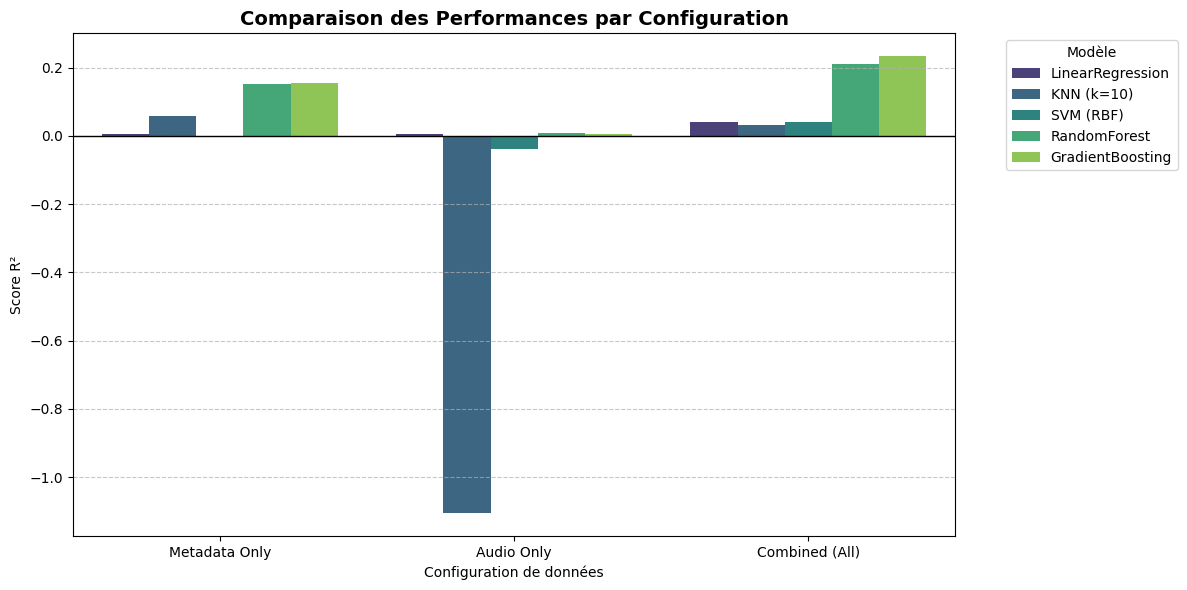

In [81]:
# ============================================
# SYNTHESE / COMPARAISON DES RESULTATS
# ============================================


# On transforme ça en tableau (DataFrame) pour que le graphique puisse le lire
results_df = pd.DataFrame(global_results)
# Vérification que global_results existe
if 'global_results' in locals() and len(global_results) > 0:
    plt.figure(figsize=(12, 6))
    
    # Barplot groupé par Configuration et coloré par Modèle
    sns.barplot(data=results_df, x='Config', y='R2', hue='Model', palette='viridis')
    
    plt.title('Comparaison des Performances par Configuration', fontsize=14, fontweight='bold')
    plt.xlabel('Configuration de données')
    plt.ylabel('Score R²')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Modèle')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ligne du 0 pour bien voir les scores négatifs
    plt.axhline(0, color='black', linewidth=1)
    
    plt.tight_layout()
    plt.show()
else:
    print(" Le tableau 'global_results' n'est pas en mémoire. Assurez-vous d'avoir lancé la cellule de synthèse.")

## 5. Analyse des Erreurs (Réel vs Prédit)

Pour conclure, nous visualisons concrètement les prédictions de notre meilleur modèle identifié (Gradient Boosting sur Combined) afin de comprendre ses limites sur les morceaux atypiques.

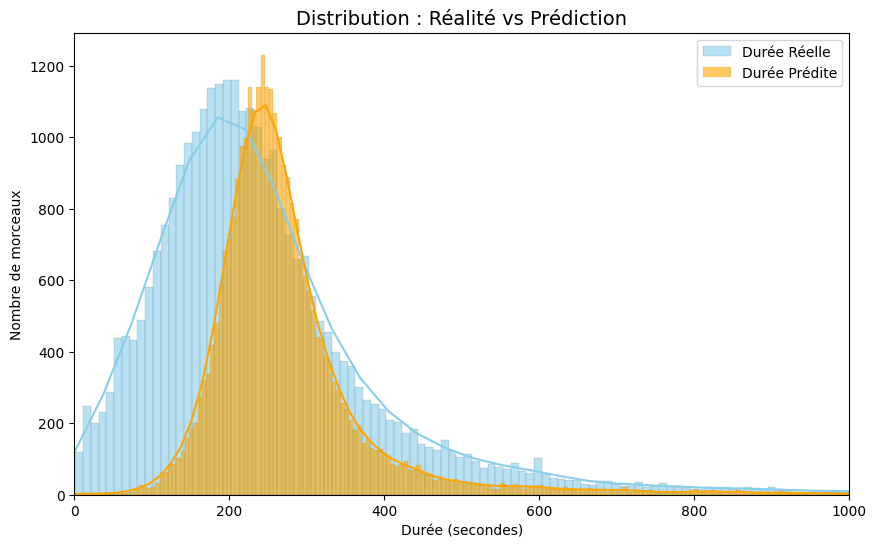

In [84]:
# ============================================
# VISUALISATION 2 : DISTRIBUTION (Réel vs Prédit)
# ============================================

plt.figure(figsize=(10, 6))

# Histogramme des valeurs réelles
sns.histplot(y_test, color="skyblue", label="Durée Réelle", kde=True, alpha=0.6)

# Histogramme des valeurs prédites
sns.histplot(y_pred, color="orange", label="Durée Prédite", kde=True, alpha=0.6)

plt.title('Distribution : Réalité vs Prédiction', fontsize=14)
plt.xlabel('Durée (secondes)')
plt.ylabel('Nombre de morceaux')
plt.legend()
plt.xlim(0, 1000) # On zoome sur l'essentiel
plt.show()